# Set-up

In [4]:
import os
os.chdir('..')

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

import matplotlib.pyplot as plt
import random
import seaborn as sns

import pandas as pd
import numpy as np
import scipy as sp
import importlib
import torch
import spacy
from torch.utils.data import \
    TensorDataset, \
    DataLoader
from transformers import \
    BertTokenizer, \
    BertForSequenceClassification, \
    AdamW, \
    BertConfig, \
    get_linear_schedule_with_warmup

import allennlp
import allennlp_models
from allennlp.models.archival import load_archive
from allennlp.common.util import JsonDict
from allennlp.data import Instance
from allennlp.predictors.predictor import Predictor
from allennlp.data.fields import LabelField
from allennlp.data.tokenizers.spacy_tokenizer import SpacyTokenizer
from typing import List, Dict
from overrides import overrides

from scipy.stats import kendalltau
from scipy.stats import spearmanr

from copy import deepcopy

import html
import random
from IPython.core.display import display, HTML

In [16]:
# cd "C:\\Users\\Da Wei\\Desktop\\UCL CSML\\COMP087\\NLP Project\\GitRepo"

C:\Users\Da Wei\Desktop\UCL CSML\COMP087\NLP Project\GitRepo


In [5]:
import sys
project_root_dir = os.path.relpath(os.path.join('..', '..'), os.curdir)
if project_root_dir not in sys.path:
    sys.path += [project_root_dir]
from src.data.dataload import *
from src.models.bcnmodel import *

ignoring warnings from spacy


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading data

In [7]:
import src.data.dataload

sst = load_sst()
agnews = load_agnews()

input_data = {'sst': sst, 'agnews': agnews}
datasets = list(input_data.keys())

In [8]:
train = {}
dev = {}
test = {}

for dataset in datasets:
    train[dataset], dev[dataset], test[dataset] = input_data[dataset].train_val_test

Using custom data configuration default
Reusing dataset ag_news (/Users/olivier/.cache/huggingface/datasets/ag_news/default/0.0.0/17ec33e23df9e89565131f989e0fdf78b0cc4672337b582da83fc3c9f79fe34d)


In [70]:
subset = deepcopy(test['sst'][:1000])

## Loading explainers

In [10]:
from src.explainers.explainers import *
from explainers import *

## Loading perturbations

In [11]:
from src.data.perturbations import add_perturbations
from src.data.perturbations import \
    remove_commas, \
    remove_all_punctuation, \
    switch_gender, \
    strip_trailing_punct, \
    add_typo, \
    change_first_name, \
    change_last_name, \
    change_location, \
    contraction, \
    swap_adjectives

In [12]:
tokenizer = SpacyTokenizer()

In [68]:
train_perturbations = add_perturbations(
    df=subset,
    tokenizer=tokenizer,
    sentence_col_name='sentence', 
    perturbation_functions=[
        remove_commas,
        remove_all_punctuation,
        switch_gender,
        strip_trailing_punct,
        add_typo,
        change_first_name,
        change_last_name,
        change_location,
        contraction,
        swap_adjectives
    ]
)

In [16]:
perturbation_reduction = ['strip_punct', 'remove_commas', 'remove_all_punct']
perturbation_list = perturbation_reduction + ['contraction','change_first_name','change_last_name', 'change_location', 'add_typo',
                  'switch_gender', 'swap_adj']

## Visualisation

Source: https://adataanalyst.com/machine-learning/highlight-text-using-weights/

In [17]:
# Prevent special characters like & and < to cause the browser to display something other than what you intended.
def html_escape(text):
    return html.escape(text)

def visualise_weights(tokens, gradients, max_alpha = 0.3):
    max_alpha = max_alpha 
    highlighted_text = []
    for i in range(len(tokens)):
        weight = gradients[i]
        highlighted_text.append('<span style="background-color:rgba(135,206,250,' + str(weight / max_alpha) + ');">' + html_escape(tokens[i]) + '</span>')
    highlighted_text = ' '.join(highlighted_text)
    print(display(HTML(highlighted_text)))

# BCN

**Set up your model & tokenizer**


The models can be downloaded from here:

https://upload.disroot.org/r/o8RgEa6y#lwPxvgfr6TDPXo/xl+u6kdGrsC5MIpaHQ3AstSZzZRg=
https://upload.disroot.org/r/_3rS3BsN#C/GGVAC1StHrFX/BEcT8zjGzGAhfWFeZc+wJ1uwyoaw=

They should then be saved in the local Github folders '/models/bcn-sst_output' or '/models/bcn-agnews_output'

In [18]:
bcn = BCNModel()
bcn.load_model(agnews)
# BCN_AG_predictor = bcn.predictor

## AllenNLP Interpret

In [73]:
AllenNLPExplainer1 = AllenNLPExplainer(bcn)

df = train_perturbations
orig_col_index = df.columns.get_loc('sentence')
tokens_col_index = df.columns.get_loc('tokens_orig')
explainer = AllenNLPExplainer1

In [75]:
rows_to_review = 1000

results_matrix = np.zeros((rows_to_review,len(perturbation_list)))

# to count the number of times every perturbation leads to a significant change in interpretation
count = {}
for perturbation in perturbation_list:
    count[perturbation] = 0

for r in range(rows_to_review):
    sentence = {}
    tokens = {}
    success = {}
    pert_indices = {}
    scores = {}
    prediction = {}
    comparison = {}

    sentence['orig'] = df.iloc[r, orig_col_index]
    tokens['orig'] = df.iloc[r,tokens_col_index]
    scores['orig'] = np.array(explainer.explain_instance(sentence['orig'])[0])
    prediction['orig'] = explainer.explain_instance(sentence['orig'])[1]
    
    # creating dict for easier reference
    for perturbation in perturbation_list:
        col_index = df.columns.get_loc(perturbation + '_concat')
        sentence[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_tokens')
        tokens[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_success')
        success[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_pert_ind')
        pert_indices[perturbation] = df.iloc[r, col_index]
        if success[perturbation] != 0:
            scores[perturbation] = np.array(explainer.explain_instance(sentence[perturbation])[0])
            prediction[perturbation] = explainer.explain_instance(sentence[perturbation])[1]
        
    for perturbation in perturbation_list:
        # interpretations should only be compared if a sentence has been modified
        if success[perturbation] == 0:
            comparison[perturbation] = None
            continue
        # interpretations should not be compared if prediction has changed
        elif prediction[perturbation] != prediction['orig']:
            comparison[perturbation] = None
            continue
        else:
            # variable to track whether an important token has been changed 
            change_flag = 0
            for i in pert_indices[perturbation]:
            # check if perturbed token is among the tokens with the 5 highest weights
                if i in np.argsort(-scores['orig'])[:5]:
                    change_flag += 1
            # interpretations should not be compared if an important token has been changed
            if change_flag > 0:   
                comparison[perturbation] = None
                continue
            else:
                # adjust list of scores to account for perturbations (as needed)
                if perturbation in perturbation_reduction: # perturbation category 1
                    # remove empty tokens from tokenised version of perturbed sentence
                    tokens[perturbation] = [tokens[perturbation][i] for i in range(len(tokens[perturbation])) 
                               if not i in pert_indices[perturbation]]
                    # remove scores of tokens that have been deleted as a result of the perturbation
                    orig_score_reduced = np.array([scores['orig'][i] for i in range(len(scores['orig'])) 
                                   if not i in pert_indices[perturbation]])
                    # normalise gradient
                    orig_score_reduced = orig_score_reduced/np.sum(orig_score_reduced)
                    orig_score_for_comparison = orig_score_reduced
                elif perturbation == 'swap_adj': # perturbation category 2
                    orig_score_swapped = deepcopy(scores['orig'])
                    for i in range(len(pert_indices[perturbation][::2])):
                        index_adj_1 = pert_indices[perturbation][i]
                        index_adj_2 = pert_indices[perturbation][i+1]
                        score_adj_1 = scores['orig'][index_adj_1]
                        score_adj_2 = scores['orig'][index_adj_2]
                        orig_score_swapped[index_adj_1] = score_adj_2
                        orig_score_swapped[index_adj_2] = score_adj_1
                    orig_score_for_comparison = orig_score_swapped
                else: # remaining perturbations
                    orig_score_for_comparison = scores['orig']
                
                if len(orig_score_for_comparison) != len(scores[perturbation]):
                    print('length not matching after perturbation')
                    comparison[perturbation] = None
                else:
                    comparison[perturbation] = spearmanr(orig_score_for_comparison, scores[perturbation])[0]
                    if comparison[perturbation] < 0.8:
                        count[perturbation] += 1
                        visualise_weights(tokens['orig'], scores['orig'])
                        visualise_weights(tokens[perturbation], scores[perturbation])
    for p in range(len(perturbation_list)):
        perturbation = perturbation_list[p]
        results_matrix[r,p] = comparison[perturbation]

None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation
length not matching after perturbation


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation
length not matching after perturbation


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation
length not matching after perturbation
length not matching after perturbation


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None
length not matching after perturbation


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation
length not matching after perturbation


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None
length not matching after perturbation


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None
length not matching after perturbation


None


None


None


None


None


None


None


None


None


None


None


None


None


None
length not matching after perturbation


In [84]:
explainer.explain_instance('Vividly conveys both the pitfalls and the pleasures of over - the - top love.')[0]

[0.41741096969370417,
 0.1437219732299129,
 0.011909441231390911,
 0.0017069827758233076,
 0.23616020830461834,
 0.01943572820008932,
 0.0013915150190660908,
 0.055832880283703916,
 0.003501957808399493,
 0.015120639641163168,
 0.012969104806893566,
 0.0013083410918502795,
 0.010478278851676933,
 0.009686014828815518,
 0.029691670717878833,
 0.02967431768943209]

In [85]:
explainer.explain_instance('Vividly conveys bot hthe pitfalls and the pleasures of over - the - top love.')[0]

[0.04974578925940652,
 0.252694063997896,
 0.018748676434653784,
 0.13466450966083124,
 0.11730944495259858,
 0.04728450401620896,
 0.005825274071808297,
 0.17869386237649476,
 0.05041388170631531,
 0.016838748270533187,
 0.007222557394600858,
 0.005050493638582567,
 0.016081634596950466,
 0.011714448640250119,
 0.05975816503546925,
 0.02795407341757793]

In [25]:
np.nanmean(results_matrix, axis = 0)

array([0.97845921, 0.95042059, 0.78822114, 0.97521083, 0.95922501,
       0.9242627 , 0.87250521, 0.8916365 , 0.92874647, 0.99543632])

Text(0, 0.5, 'Density')

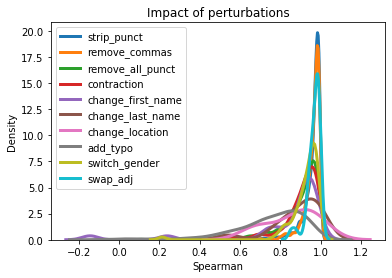

In [89]:
# Iterate through the five airlines
for p in range(10):
    # Subset to the airline
    subset = results_matrix[:,p]
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = perturbation_list[p])
    
# Plot formatting
# plt.legend(prop={'size': 16}, title = 'Perturbation')
plt.title('Impact of perturbations')
plt.xlabel('Spearman')
plt.ylabel('Density')

# LIME

In [63]:
cd "C:\Users\Da Wei\Desktop\UCL CSML\COMP087\NLP Project\GitRepo"

C:\Users\Da Wei\Desktop\UCL CSML\COMP087\NLP Project\GitRepo


In [66]:
import importlib
from src.explainers.explainers import *
import explainers.explainers
importlib.reload(explainers.explainers)

<module 'explainers.explainers' from 'C:\\Users\\Da Wei\\Desktop\\UCL CSML\\COMP087\\NLP Project\\GitRepo\\src\\explainers\\explainers.py'>

In [96]:
bcn = BCNModel()
bcn.load_model(sst)
# BCN_AG_predictor = bcn.predictor

error loading _jsonnet (this is expected on Windows), treating C:\Users\DAWEI~1\AppData\Local\Temp\tmps0jkugwb\config.json as plain json


In [97]:
LimeExplainer1 = LimeExplainer(bcn,1000)
import warnings
warnings.filterwarnings('ignore')

**Notes**
<br>LIME ignores punctuation when counting token position
<br>It also automatically splits contractions into separate tokens, e.g. "You've" into "You" and " 've".
<br>It regards multiple word occurences as 1 feature and returns indices for the 1st occurence.

**Hence the evaluation loop is different for LIME than for AllenNLP gradient!**

In [98]:
perturbation_list = perturbation_reduction + ['contraction','change_first_name','change_last_name', 'change_location', 'add_typo',
                  'switch_gender', 'swap_adj']

In [101]:
from tqdm import tqdm
df = train_perturbations
orig_col_index = df.columns.get_loc('sentence')
tokens_col_index = df.columns.get_loc('tokens_orig')
explainer = LimeExplainer1

N=5
rows_to_review = 150

max_alpha=0.08

mean_list=[]
#row_indices = [16,17,18,19,20]

#perturbation_list=['add_typo']

results_matrix = np.zeros((rows_to_review,len(perturbation_list)))
results_matrix_2 = np.zeros((rows_to_review,len(perturbation_list)))

# to count the number of times every perturbation leads to a significant change in interpretation
count_LIME_BCN = {}
for perturbation in perturbation_list:
    count_LIME_BCN[perturbation] = 0

#for r in [18]:
for r in tqdm(range(rows_to_review)):

    sentence = {}
    tokens = {}
    success = {}
    pert_indices = {}
    scores = {}
    prediction = {}
    comparison = {}
    top_K_intersect = {}
    exp_indices= {} #to store indices returned by the explainer

    sentence['orig'] = df.iloc[r, orig_col_index]

    X = explainer.explain_instance(sentence['orig'])     
    tokens['orig'] = X[3]
    scores['orig'] = np.array(X[0])
    prediction['orig'] = X[1]
    exp_indices['orig'] = X[2]
    
    print('Original: ',sentence['orig'])


    # creating dict for easier reference
    for perturbation in perturbation_list:


        col_index = df.columns.get_loc(perturbation + '_concat')
        sentence[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_tokens')
        tokens[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_success')
        success[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_pert_ind')
        pert_indices[perturbation] = df.iloc[r, col_index]
        
        if success[perturbation] != 0:
            try:
                X = explainer.explain_instance(sentence[perturbation])
                scores[perturbation] = np.array(X[0])
                prediction[perturbation] = X[1]
                tokens[perturbation] = X[3]
                exp_indices[perturbation]=X[2]
            except:
                print('\n'+'numerical overflow')
                print(perturbation)
                print(sentence[perturbation])
                scores[perturbation] = scores['orig']
                prediction[perturbation] = prediction['orig']
                tokens[perturbation] = tokens['orig']
                exp_indices[perturbation]=exp_indices['orig']

    for perturbation in perturbation_list:

        #COMPARE ONLY IF SENTENCE WAS CHANGED

        if success[perturbation] == 0:
            comparison[perturbation] = None
            continue

        #COMPARE ONLY IF PREDICTION NOT CHANGED

        elif prediction[perturbation] != prediction['orig']:
            comparison[perturbation] = None
            continue
            
        #COMPARE ONLY IF WEIGHTS ARE ABOVE THRESHOLD SIZE
        elif max(scores['orig'])<0.05:
            comparison[perturbation] = None
            continue            
    
        else:
            #COMPARE ONLY IF UN-IMPORTANT TOKEN CHANGED

            #original top_5 tokens
            top_5_orig = set(tokens['orig'][:5])

            #check if these were changed in perturbed sentence
            new_tokens = set(tokens[perturbation])

            intersections = top_5_orig.intersection(new_tokens)

            if len(intersections)<5:   
                comparison[perturbation] = None                 
                continue

            else:

                #DELETED TOKENS ARE PUNCTUATION, COMMMAS WHICH LIME IGNORES - SKIP THIS PERTURBATION
                #BUT DON'T SKIP ADJUSTING INDICES WHEN SWAPPING ADJECTIVES
                if perturbation == 'swap_adj': # perturbation category 2
                    orig_score_swapped = deepcopy(scores['orig'])

                    #swapped words - need to get from original sentence

                    for i in range(len(pert_indices[perturbation][::2])):
                        index_adj_1 = pert_indices[perturbation][i]
                        index_adj_2 = pert_indices[perturbation][i+1]

                        token_adj_1 = df.tokens_orig.iloc[r][index_adj_1]
                        token_adj_2 = df.tokens_orig.iloc[r][index_adj_2]

                        print(token_adj_1,token_adj_2)

                    #find the corresponding LIME indices
                        index_adj_1=tokens['orig'].index(token_adj_1)
                        index_adj_2 =tokens['orig'].index(token_adj_2)

                        score_adj_1 = scores['orig'][index_adj_1]
                        score_adj_2 = scores['orig'][index_adj_2]
                        orig_score_swapped[index_adj_1] = score_adj_2
                        orig_score_swapped[index_adj_2] = score_adj_1
                    orig_score_for_comparison = orig_score_swapped
                else: # remaining perturbations
                    orig_score_for_comparison = scores['orig']

                if len(orig_score_for_comparison) != len(scores[perturbation]):
                    print('length not matching after perturbation: ',perturbation)
                    comparison[perturbation] = None

                else:

                    #sort the score arrays according to position - as they were originally sorted by weights
                    #first compute top-K intersections
                    K=5
                    
                    top_K_orig = set(tokens['orig'][:K])
                    top_K_perturb = set(tokens[perturbation][:K])
                    intersections = top_K_orig.intersection(top_K_perturb)
                    
                    top_K_intersect[perturbation] = len(intersections)/K
                   # print(perturbation)
                   # print(sentence[perturbation])
                    print('\n'+perturbation)
                    print(top_K_orig)
                    print(top_K_perturb)
                    
                    print('top K: ',len(intersections)/K)
                    
                    #print(perturbation,':  ',tokens['orig'][:5],tokens[perturbation][:5])
                    #print(perturbation,':  ',scores['orig'][:5],scores[perturbation][:5])

                    zipped_lists = zip(exp_indices['orig'],scores['orig'],tokens['orig'])
                    sorted_tuples = sorted(zipped_lists)
                    tuples = zip(*sorted_tuples)
                    _, orig_scores,orig_tokens= [ list(tuple) for tuple in  tuples]
                    
                    zipped_lists = zip(exp_indices[perturbation],scores[perturbation],tokens[perturbation])
                    sorted_tuples = sorted(zipped_lists)
                    tuples = zip(*sorted_tuples)
                    _, perturb_scores,perturb_tokens= [ list(tuple) for tuple in  tuples]
                    
                    #print(orig_tokens[:20])
                    #print(perturb_tokens[:20])
                    #print(['{:.3f}'.format(x) for x in orig_scores])
                    #print(['{:.3f}'.format(x) for x in perturb_scores])
                    
                    comparison[perturbation] = spearmanr(orig_scores, perturb_scores)[0]
                    #print(comparison[perturbation])
                    print('Spearman: ',comparison[perturbation])
                    

                    if (comparison[perturbation] < 0.7):

                       # print(comparison[perturbation]==None,'XX')
                        print('Sentence: ',sentence[perturbation])                       
                                            

                        count_LIME_BCN[perturbation] += 1
                        #visualise_weights(orig_tokens, orig_scores,max_alpha=max_alpha)
                        #visualise_weights(perturb_tokens, perturb_scores,max_alpha=max_alpha)

                        #print(comparison[perturbation],perturbation)
                        #print(['{:.3f}'.format(x) for x in orig_scores])
                        #print(['{:.3f}'.format(x) for x in perturb_scores])

    for p in range(len(perturbation_list)):
        perturbation = perturbation_list[p]
        
        try:
            results_matrix_2[r,p] = top_K_intersect[perturbation]
        except:
            results_matrix_2[r,p] = None

        results_matrix[r,p] = comparison[perturbation]

    mean_list.append(np.nanmean(results_matrix, axis = 0))

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

Original:  Effective but too-tepid biopic


  1%|▌                                                                                 | 1/150 [00:06<15:15,  6.14s/it]


remove_all_punct
{'Effective', 'too', 'but', 'biopic', 'tepid'}
{'Effective', 'too', 'but', 'biopic', 'tepid'}
top K:  1.0
Spearman:  0.9999999999999999
Original:  If you sometimes like to go to the movies to have fun , Wasabi is a good place to start .


  1%|█                                                                                 | 2/150 [00:21<22:18,  9.04s/it]


strip_punct
{'is', 'fun', 'good', 'a', 'Wasabi'}
{'is', 'you', 'fun', 'good', 'Wasabi'}
top K:  0.8
Spearman:  0.9705882352941176

remove_commas
{'is', 'fun', 'good', 'a', 'Wasabi'}
{'you', 'fun', 'good', 'a', 'Wasabi'}
top K:  0.8
Spearman:  0.9823529411764707

remove_all_punct
{'is', 'fun', 'good', 'a', 'Wasabi'}
{'you', 'fun', 'good', 'a', 'Wasabi'}
top K:  0.8
Spearman:  0.9441176470588234
length not matching after perturbation:  add_typo
Original:  Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .


  2%|█▋                                                                                | 3/150 [00:42<30:31, 12.46s/it]


strip_punct
{'rare', 'so', 'and', 's', 'honest'}
{'rare', 'so', 'and', 's', 'honest'}
top K:  1.0
Spearman:  0.9792207792207792
length not matching after perturbation:  add_typo
Original:  The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .


  3%|██▏                                                                               | 4/150 [00:59<33:48, 13.89s/it]


strip_punct
{'insight', 'great', 'provides', 'mindset', 'neurotic'}
{'insight', 'great', 'provides', 'mindset', 'neurotic'}
top K:  1.0
Spearman:  0.9662337662337662

remove_all_punct
{'insight', 'great', 'provides', 'mindset', 'neurotic'}
{'insight', 'great', 'provides', 'mindset', 'neurotic'}
top K:  1.0
Spearman:  0.9584415584415583

contraction
{'insight', 'great', 'provides', 'mindset', 'neurotic'}
{'insight', 'great', 'provides', 'mindset', 'neurotic'}
top K:  1.0
Spearman:  0.9883116883116884
Original:  Offers that rare combination of entertainment and education .


  3%|██▋                                                                               | 5/150 [01:08<29:47, 12.33s/it]


strip_punct
{'entertainment', 'rare', 'and', 'Offers', 'combination'}
{'entertainment', 'rare', 'and', 'Offers', 'combination'}
top K:  1.0
Spearman:  0.9523809523809524

remove_all_punct
{'entertainment', 'rare', 'and', 'Offers', 'combination'}
{'entertainment', 'rare', 'and', 'Offers', 'combination'}
top K:  1.0
Spearman:  0.9523809523809524
Original:  Perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .


  4%|███▎                                                                              | 6/150 [01:20<29:16, 12.20s/it]


strip_punct
{'Perhaps', 'hell', 'showed', 'no', 'intentions'}
{'Perhaps', 'showed', 'no', 'paved', 'intentions'}
top K:  0.8
Spearman:  0.9298245614035087

remove_all_punct
{'Perhaps', 'hell', 'showed', 'no', 'intentions'}
{'Perhaps', 'hell', 'showed', 'no', 'intentions'}
top K:  1.0
Spearman:  0.9403508771929823

add_typo
{'Perhaps', 'hell', 'showed', 'no', 'intentions'}
{'tthe', 'Perhaps', 'showed', 'tha', 'intentions'}
top K:  0.6
Spearman:  0.6508771929824562
Sentence:  Perhaps no picture ever made has more literally showed tha tthe road to hell is paved with good intentions .
Original:  Steers turns in a snappy screenplay that curls at the edges ; it 's so clever you want to hate it .


  5%|███▊                                                                              | 7/150 [01:36<32:08, 13.48s/it]


strip_punct
{'you', 's', 'clever', 'edges', 'snappy'}
{'you', 'so', 's', 'clever', 'snappy'}
top K:  0.8
Spearman:  0.9789473684210527

remove_all_punct
{'you', 's', 'clever', 'edges', 'snappy'}
{'you', 'so', 'clever', 'edges', 'snappy'}
top K:  0.8
Spearman:  0.9017543859649122
Original:  But he somehow pulls it off .


  5%|████▎                                                                             | 8/150 [01:47<29:44, 12.57s/it]


strip_punct
{'off', 'But', 'it', 'somehow', 'he'}
{'off', 'But', 'it', 'somehow', 'he'}
top K:  1.0
Spearman:  0.8285714285714287

remove_all_punct
{'off', 'But', 'it', 'somehow', 'he'}
{'off', 'But', 'it', 'somehow', 'he'}
top K:  1.0
Spearman:  0.942857142857143
Original:  Take Care of My Cat offers a refreshingly different slice of Asian cinema .


  6%|████▉                                                                             | 9/150 [01:57<27:43, 11.80s/it]


strip_punct
{'Take', 'Cat', 'slice', 'Care', 'My'}
{'Take', 'Cat', 'slice', 'Care', 'My'}
top K:  1.0
Spearman:  0.9930069930069931

remove_all_punct
{'Take', 'Cat', 'slice', 'Care', 'My'}
{'Cat', 'slice', 'Asian', 'Care', 'My'}
top K:  0.8
Spearman:  0.9860139860139862
Original:  This is a film well worth seeing , talking and singing heads and all .


  7%|█████▍                                                                           | 10/150 [02:10<28:39, 12.28s/it]


strip_punct
{'film', 'well', 'singing', 'and', 'worth'}
{'well', 'singing', 'and', 'all', 'worth'}
top K:  0.8
Spearman:  0.9930069930069931

remove_commas
{'film', 'well', 'singing', 'and', 'worth'}
{'film', 'well', 'singing', 'and', 'worth'}
top K:  1.0
Spearman:  1.0

remove_all_punct
{'film', 'well', 'singing', 'and', 'worth'}
{'well', 'singing', 'and', 'all', 'worth'}
top K:  0.8
Spearman:  0.9930069930069931
Original:  What really surprises about Wisegirls is its low-key quality and genuine tenderness .


  7%|█████▉                                                                           | 11/150 [02:23<29:07, 12.57s/it]


strip_punct
{'surprises', 'tenderness', 'What', 'really', 'about'}
{'surprises', 'tenderness', 'key', 'What', 'really'}
top K:  0.8
Spearman:  0.8406593406593407

remove_all_punct
{'surprises', 'tenderness', 'What', 'really', 'about'}
{'surprises', 'tenderness', 'What', 'really', 'about'}
top K:  1.0
Spearman:  0.9230769230769231

add_typo
{'surprises', 'tenderness', 'What', 'really', 'about'}
{'surprises', 'tenderness', 'key', 'What', 'really'}
top K:  0.8
Spearman:  0.7637362637362637
quality genuine

swap_adj
{'surprises', 'tenderness', 'What', 'really', 'about'}
{'surprises', 'tenderness', 'key', 'What', 'really'}
top K:  0.8
Spearman:  0.9120879120879121
Original:  ( Wendigo is ) why we go to the cinema : to be fed through the eye , the heart , the mind .


  8%|██████▍                                                                          | 12/150 [02:40<31:57, 13.89s/it]


strip_punct
{'heart', 'mind', 'why', 'we', 'eye'}
{'heart', 'mind', 'why', 'we', 'eye'}
top K:  1.0
Spearman:  0.9120879120879121

remove_commas
{'heart', 'mind', 'why', 'we', 'eye'}
{'heart', 'mind', 'cinema', 'we', 'eye'}
top K:  0.8
Spearman:  0.6439560439560439
Sentence:  ( Wendigo is ) why we go to the cinema : to be fed through the eye  the heart  the mind .

remove_all_punct
{'heart', 'mind', 'why', 'we', 'eye'}
{'heart', 'mind', 'why', 'we', 'eye'}
top K:  1.0
Spearman:  0.7758241758241758
length not matching after perturbation:  add_typo
Original:  One of the greatest family-oriented , fantasy-adventure movies ever .


  9%|███████                                                                          | 13/150 [02:53<31:14, 13.68s/it]


strip_punct
{'family', 'adventure', 'fantasy', 'oriented', 'greatest'}
{'family', 'ever', 'adventure', 'movies', 'greatest'}
top K:  0.6
Spearman:  0.5393939393939393
Sentence:  One of the greatest family - oriented , fantasy - adventure movies ever 

remove_commas
{'family', 'adventure', 'fantasy', 'oriented', 'greatest'}
{'family', 'ever', 'adventure', 'movies', 'greatest'}
top K:  0.6
Spearman:  0.5393939393939393
Sentence:  One of the greatest family - oriented  fantasy - adventure movies ever .

remove_all_punct
{'family', 'adventure', 'fantasy', 'oriented', 'greatest'}
{'family', 'ever', 'adventure', 'movies', 'greatest'}
top K:  0.6
Spearman:  0.43030303030303024
Sentence:  One of the greatest family  oriented  fantasy  adventure movies ever 
Original:  Ultimately , it ponders the reasons we need stories so much .


  9%|███████▌                                                                         | 14/150 [03:05<29:46, 13.14s/it]


strip_punct
{'it', 'much', 'need', 'reasons', 'ponders'}
{'it', 'much', 'need', 'reasons', 'ponders'}
top K:  1.0
Spearman:  0.9999999999999999

remove_commas
{'it', 'much', 'need', 'reasons', 'ponders'}
{'it', 'much', 'need', 'reasons', 'ponders'}
top K:  1.0
Spearman:  0.9999999999999999

remove_all_punct
{'it', 'much', 'need', 'reasons', 'ponders'}
{'much', 'need', 'stories', 'reasons', 'ponders'}
top K:  0.8
Spearman:  0.9636363636363635

add_typo
{'it', 'much', 'need', 'reasons', 'ponders'}
{'sso', 'reasons', 'Ultimately', 'ponders', 'storie'}
top K:  0.4
Spearman:  0.4666666666666666
Sentence:  Ultimately , it ponders the reasons we need storie sso much .
Original:  An utterly compelling ` who wrote it ' in which the reputation of the most famous author who ever lived comes into question .


 10%|████████                                                                         | 15/150 [03:19<29:41, 13.20s/it]


strip_punct
{'reputation', 'question', 'compelling', 'famous', 'lived'}
{'reputation', 'question', 'compelling', 'An', 'famous'}
top K:  0.8
Spearman:  0.9701754385964911

remove_all_punct
{'reputation', 'question', 'compelling', 'famous', 'lived'}
{'it', 'question', 'compelling', 'An', 'lived'}
top K:  0.6
Spearman:  0.9070175438596491

add_typo
{'reputation', 'question', 'compelling', 'famous', 'lived'}
{'reputation', 'question', 'compelling', 'famous', 'lived'}
top K:  1.0
Spearman:  0.9175438596491228
Original:  Illuminating if overly talky documentary .


 11%|████████▋                                                                        | 16/150 [03:26<25:53, 11.59s/it]


strip_punct
{'talky', 'Illuminating', 'documentary', 'if', 'overly'}
{'talky', 'Illuminating', 'documentary', 'if', 'overly'}
top K:  1.0
Spearman:  0.7

remove_all_punct
{'talky', 'Illuminating', 'documentary', 'if', 'overly'}
{'talky', 'Illuminating', 'documentary', 'if', 'overly'}
top K:  1.0
Spearman:  0.7
Original:  A masterpiece four years in the making .


 11%|█████████▏                                                                       | 17/150 [03:35<23:42, 10.69s/it]


strip_punct
{'four', 'years', 'the', 'masterpiece', 'A'}
{'A', 'four', 'years', 'masterpiece', 'in'}
top K:  0.8
Spearman:  0.8928571428571429

remove_all_punct
{'four', 'years', 'the', 'masterpiece', 'A'}
{'four', 'years', 'making', 'masterpiece', 'A'}
top K:  0.8
Spearman:  0.8571428571428573
Original:  The movie 's ripe , enrapturing beauty will tempt those willing to probe its inscrutable mysteries .


 12%|█████████▋                                                                       | 18/150 [03:50<26:04, 11.85s/it]

Original:  Offers a breath of the fresh air of true sophistication .


 13%|██████████▎                                                                      | 19/150 [04:00<24:35, 11.27s/it]


strip_punct
{'fresh', 'Offers', 'true', 'breath', 'sophistication'}
{'fresh', 'Offers', 'true', 'breath', 'sophistication'}
top K:  1.0
Spearman:  0.9833333333333333

remove_all_punct
{'fresh', 'Offers', 'true', 'breath', 'sophistication'}
{'fresh', 'Offers', 'true', 'breath', 'sophistication'}
top K:  1.0
Spearman:  1.0
Original:  A thoughtful , provocative , insistently humanizing film .


 13%|██████████▊                                                                      | 20/150 [04:11<24:14, 11.19s/it]


strip_punct
{'film', 'thoughtful', 'humanizing', 'provocative', 'A'}
{'film', 'thoughtful', 'humanizing', 'provocative', 'A'}
top K:  1.0
Spearman:  0.942857142857143
Original:  With a cast that includes some of the top actors working in independent film , Lovely & Amazing involves us because it is so incisive , so bleakly amusing about how we go about our lives .


 14%|███████████▎                                                                     | 21/150 [04:37<33:46, 15.71s/it]


strip_punct
{'independent', 'Amazing', 'us', 'incisive', 'Lovely'}
{'independent', 'Amazing', 'us', 'incisive', 'Lovely'}
top K:  1.0
Spearman:  0.992741935483871

remove_commas
{'independent', 'Amazing', 'us', 'incisive', 'Lovely'}
{'independent', 'Amazing', 'us', 'incisive', 'Lovely'}
top K:  1.0
Spearman:  0.9951612903225807

remove_all_punct
{'independent', 'Amazing', 'us', 'incisive', 'Lovely'}
{'independent', 'Amazing', 'us', 'incisive', 'Lovely'}
top K:  1.0
Spearman:  0.9915322580645162

contraction
{'independent', 'Amazing', 'us', 'incisive', 'Lovely'}
{'independent', 's', 'Amazing', 'incisive', 'Lovely'}
top K:  0.8
Spearman:  0.9197580645161291

add_typo
{'independent', 'Amazing', 'us', 'incisive', 'Lovely'}
{'independent', 'Amazing', 'us', 'incisive', 'Lovely'}
top K:  1.0
Spearman:  0.8931451612903226
Original:  A disturbing and frighteningly evocative assembly of imagery and hypnotic music composed by Philip Glass .


 15%|███████████▉                                                                     | 22/150 [04:53<33:58, 15.92s/it]


strip_punct
{'assembly', 'disturbing', 'Philip', 'imagery', 'A'}
{'assembly', 'disturbing', 'Philip', 'imagery', 'A'}
top K:  1.0
Spearman:  0.9780219780219781

remove_all_punct
{'assembly', 'disturbing', 'Philip', 'imagery', 'A'}
{'assembly', 'disturbing', 'Philip', 'imagery', 'A'}
top K:  1.0
Spearman:  0.9736263736263736

change_last_name
{'assembly', 'disturbing', 'Philip', 'imagery', 'A'}
{'assembly', 'disturbing', 'Philip', 'imagery', 'evocative'}
top K:  0.8
Spearman:  0.9032967032967033
Original:  Not for everyone , but for those with whom it will connect , it 's a nice departure from standard moviegoing fare .


 15%|████████████▍                                                                    | 23/150 [05:14<36:37, 17.30s/it]


strip_punct
{'it', 'fare', 'moviegoing', 's', 'nice'}
{'it', 'moviegoing', 'with', 's', 'nice'}
top K:  0.8
Spearman:  0.9690402476780186

remove_commas
{'it', 'fare', 'moviegoing', 's', 'nice'}
{'it', 'moviegoing', 'with', 'everyone', 'nice'}
top K:  0.6
Spearman:  0.9669762641898865

remove_all_punct
{'it', 'fare', 'moviegoing', 's', 'nice'}
{'it', 'moviegoing', 'with', 'everyone', 'nice'}
top K:  0.6
Spearman:  0.8802889576883385
length not matching after perturbation:  add_typo
Original:  Scores a few points for doing what it does with a dedicated and good-hearted professionalism .


 16%|████████████▉                                                                    | 24/150 [05:28<34:31, 16.44s/it]


strip_punct
{'with', 'hearted', 'good', 'dedicated', 'professionalism'}
{'hearted', 'good', 'professionalism', 'Scores', 'few'}
top K:  0.6
Spearman:  0.7249999999999999

remove_all_punct
{'with', 'hearted', 'good', 'dedicated', 'professionalism'}
{'hearted', 'good', 'professionalism', 'Scores', 'few'}
top K:  0.6
Spearman:  0.39642857142857135
Sentence:  Scores a few points for doing what it does with a dedicated and good  hearted professionalism 
dedicated good

swap_adj
{'with', 'hearted', 'good', 'dedicated', 'professionalism'}
{'hearted', 'good', 'Scores', 'points', 'few'}
top K:  0.4
Spearman:  0.18928571428571428
Sentence:  Scores a few points for doing what it does with a good and dedicated - hearted professionalism .
Original:  Occasionally melodramatic , it 's also extremely effective .


 17%|█████████████▌                                                                   | 25/150 [05:42<32:29, 15.60s/it]


strip_punct
{'it', 's', 'also', 'effective', 'extremely'}
{'it', 's', 'also', 'effective', 'extremely'}
top K:  1.0
Spearman:  1.0

remove_commas
{'it', 's', 'also', 'effective', 'extremely'}
{'it', 's', 'also', 'effective', 'extremely'}
top K:  1.0
Spearman:  0.9642857142857145

remove_all_punct
{'it', 's', 'also', 'effective', 'extremely'}
{'it', 's', 'also', 'effective', 'extremely'}
top K:  1.0
Spearman:  0.8928571428571429
Original:  An idealistic love story that brings out the latent 15-year-old romantic in everyone .


 17%|██████████████                                                                   | 26/150 [05:54<29:53, 14.46s/it]


strip_punct
{'love', 'romantic', 'everyone', 'idealistic', 'brings'}
{'love', 'An', 'romantic', 'idealistic', 'brings'}
top K:  0.8
Spearman:  0.825

remove_all_punct
{'love', 'romantic', 'everyone', 'idealistic', 'brings'}
{'love', 'An', 'romantic', 'idealistic', 'brings'}
top K:  0.8
Spearman:  0.5928571428571427
Sentence:  An idealistic love story that brings out the latent 15  year  old romantic in everyone 
Original:  At about 95 minutes , Treasure Planet maintains a brisk pace as it races through the familiar story .


 18%|██████████████▌                                                                  | 27/150 [06:08<29:50, 14.55s/it]


strip_punct
{'brisk', 'Treasure', 'pace', 'maintains', 'familiar'}
{'brisk', 'Treasure', 'pace', 'maintains', 'races'}
top K:  0.8
Spearman:  0.9191176470588237

remove_commas
{'brisk', 'Treasure', 'pace', 'maintains', 'familiar'}
{'brisk', 'Treasure', 'pace', 'maintains', 'familiar'}
top K:  1.0
Spearman:  0.9558823529411765

remove_all_punct
{'brisk', 'Treasure', 'pace', 'maintains', 'familiar'}
{'brisk', 'Treasure', 'pace', 'maintains', 'races'}
top K:  0.8
Spearman:  0.9362745098039217

add_typo
{'brisk', 'Treasure', 'pace', 'maintains', 'familiar'}
{'brisk', 'Treasure', 'pace', 'maintains', 'race'}
top K:  0.8
Spearman:  0.8014705882352942
Original:  However , it lacks grandeur and that epic quality often associated with Stevenson 's tale as well as with earlier Disney efforts .


 19%|███████████████                                                                  | 28/150 [06:28<32:47, 16.13s/it]


strip_punct
{'quality', 'well', 'However', 'with', 'epic'}
{'quality', 'well', 'However', 'with', 'epic'}
top K:  1.0
Spearman:  0.9070175438596491

remove_commas
{'quality', 'well', 'However', 'with', 'epic'}
{'quality', 'well', 'However', 'with', 'epic'}
top K:  1.0
Spearman:  0.9315789473684211

remove_all_punct
{'quality', 'well', 'However', 'with', 'epic'}
{'quality', 'well', 'However', 'with', 'epic'}
top K:  1.0
Spearman:  0.9192982456140351

change_first_name
{'quality', 'well', 'However', 'with', 'epic'}
{'quality', 'well', 'However', 'with', 'epic'}
top K:  1.0
Spearman:  0.9175438596491228
length not matching after perturbation:  add_typo
Original:  It helps that Lil Bow Wow ... tones down his pint-sized gangsta act to play someone who resembles a real kid .


 19%|███████████████▋                                                                 | 29/150 [06:45<33:10, 16.45s/it]


strip_punct
{'resembles', 'gangsta', 'Bow', 'down', 'Lil'}
{'resembles', 'gangsta', 'Bow', 'down', 'Lil'}
top K:  1.0
Spearman:  0.9753246753246754

remove_all_punct
{'resembles', 'gangsta', 'Bow', 'down', 'Lil'}
{'resembles', 'gangsta', 'Bow', 'down', 'Lil'}
top K:  1.0
Spearman:  0.9753246753246754
length not matching after perturbation:  add_typo

switch_gender
{'resembles', 'gangsta', 'Bow', 'down', 'Lil'}
{'resembles', 'gangsta', 'Bow', 'down', 'Lil'}
top K:  1.0
Spearman:  0.9805194805194805
Original:  Guaranteed to move anyone who ever shook , rattled , or rolled .


 20%|████████████████▏                                                                | 30/150 [06:58<30:36, 15.30s/it]


strip_punct
{'rattled', 'anyone', 'Guaranteed', 'shook', 'or'}
{'rattled', 'anyone', 'Guaranteed', 'shook', 'or'}
top K:  1.0
Spearman:  0.9757575757575757

remove_commas
{'rattled', 'anyone', 'Guaranteed', 'shook', 'or'}
{'rolled', 'rattled', 'Guaranteed', 'shook', 'or'}
top K:  0.8
Spearman:  0.9393939393939393

remove_all_punct
{'rattled', 'anyone', 'Guaranteed', 'shook', 'or'}
{'rolled', 'rattled', 'Guaranteed', 'shook', 'or'}
top K:  0.8
Spearman:  0.8303030303030302
Original:  A masterful film from a master filmmaker , unique in its deceptive grimness , compelling in its fatalist worldview .


 21%|████████████████▋                                                                | 31/150 [07:13<30:25, 15.34s/it]


strip_punct
{'compelling', 'filmmaker', 'unique', 'masterful', 'master'}
{'compelling', 'filmmaker', 'unique', 'masterful', 'master'}
top K:  1.0
Spearman:  0.9928571428571428

remove_commas
{'compelling', 'filmmaker', 'unique', 'masterful', 'master'}
{'compelling', 'filmmaker', 'unique', 'masterful', 'master'}
top K:  1.0
Spearman:  1.0

remove_all_punct
{'compelling', 'filmmaker', 'unique', 'masterful', 'master'}
{'compelling', 'filmmaker', 'unique', 'masterful', 'master'}
top K:  1.0
Spearman:  0.9785714285714284
Original:  Light , cute and forgettable .


 21%|█████████████████▎                                                               | 32/150 [07:25<28:12, 14.34s/it]

Original:  If there 's a way to effectively teach kids about the dangers of drugs , I think it 's in projects like the ( unfortunately R-rated ) Paid .


 22%|█████████████████▊                                                               | 33/150 [07:51<34:34, 17.73s/it]


strip_punct
{'drugs', 'think', 'unfortunately', 'If', 'Paid'}
{'drugs', 'think', 'unfortunately', 'If', 'Paid'}
top K:  1.0
Spearman:  0.9539130434782607

remove_commas
{'drugs', 'think', 'unfortunately', 'If', 'Paid'}
{'drugs', 'unfortunately', 'If', 'Paid', 'there'}
top K:  0.8
Spearman:  0.9582608695652173

remove_all_punct
{'drugs', 'think', 'unfortunately', 'If', 'Paid'}
{'drugs', 'think', 'unfortunately', 'If', 'Paid'}
top K:  1.0
Spearman:  0.8956521739130434

contraction
{'drugs', 'think', 'unfortunately', 'If', 'Paid'}
{'drugs', 'think', 'unfortunately', 'If', 'Paid'}
top K:  1.0
Spearman:  0.8999999999999999
length not matching after perturbation:  add_typo
Original:  While it would be easy to give Crush the new title of Two Weddings and a Funeral , it 's a far more thoughtful film than any slice of Hugh Grant whimsy .


 23%|██████████████████▎                                                              | 34/150 [08:17<39:08, 20.24s/it]


strip_punct
{'easy', 'whimsy', 'thoughtful', 'Weddings', 'Hugh'}
{'easy', 'whimsy', 'thoughtful', 'Weddings', 'Hugh'}
top K:  1.0
Spearman:  0.9529282977558841

remove_commas
{'easy', 'whimsy', 'thoughtful', 'Weddings', 'Hugh'}
{'easy', 'whimsy', 'thoughtful', 'Weddings', 'Hugh'}
top K:  1.0
Spearman:  0.9594964422550629

remove_all_punct
{'easy', 'whimsy', 'thoughtful', 'Weddings', 'Hugh'}
{'easy', 'whimsy', 'thoughtful', 'Weddings', 'Hugh'}
top K:  1.0
Spearman:  0.912424740010947

contraction
{'easy', 'whimsy', 'thoughtful', 'Weddings', 'Hugh'}
{'easy', 'whimsy', 'thoughtful', 'Weddings', 'Hugh'}
top K:  1.0
Spearman:  0.9463601532567051

add_typo
{'easy', 'whimsy', 'thoughtful', 'Weddings', 'Hugh'}
{'easy', 'whimsy', 'thoughtful', 'Weddings', 'Hugh'}
top K:  1.0
Spearman:  0.9195402298850575
Original:  Though everything might be literate and smart , it never took off and always seemed static .


 23%|██████████████████▉                                                              | 35/150 [08:34<37:04, 19.34s/it]


remove_commas
{'static', 'off', 'might', 'seemed', 'took'}
{'static', 'off', 'might', 'seemed', 'took'}
top K:  1.0
Spearman:  0.9868131868131869

remove_all_punct
{'static', 'off', 'might', 'seemed', 'took'}
{'static', 'off', 'might', 'seemed', 'took'}
top K:  1.0
Spearman:  0.9912087912087912
length not matching after perturbation:  add_typo
literate smart

swap_adj
{'static', 'off', 'might', 'seemed', 'took'}
{'static', 'off', 'might', 'seemed', 'took'}
top K:  1.0
Spearman:  0.9912087912087912
Original:  Cantet perfectly captures the hotel lobbies , two-lane highways , and roadside cafes that permeate Vincent 's days


 24%|███████████████████▍                                                             | 36/150 [08:50<34:45, 18.30s/it]


remove_commas
{'Cantet', 'perfectly', 'captures', 'Vincent', 'highways'}
{'Cantet', 'perfectly', 'captures', 'Vincent', 'highways'}
top K:  1.0
Spearman:  0.9926470588235295

remove_all_punct
{'Cantet', 'perfectly', 'captures', 'Vincent', 'highways'}
{'Cantet', 'perfectly', 'captures', 'highways', 'the'}
top K:  0.8
Spearman:  0.9754901960784315
Original:  Ms. Fulford-Wierzbicki is almost spooky in her sulky , calculating Lolita turn .


 25%|███████████████████▉                                                             | 37/150 [09:08<33:51, 17.98s/it]


strip_punct
{'spooky', 'Fulford', 'her', 'Wierzbicki', 'in'}
{'spooky', 'her', 'Wierzbicki', 'Lolita', 'in'}
top K:  0.8
Spearman:  0.9300699300699302

remove_commas
{'spooky', 'Fulford', 'her', 'Wierzbicki', 'in'}
{'spooky', 'her', 'Wierzbicki', 'Lolita', 'in'}
top K:  0.8
Spearman:  0.9300699300699302

remove_all_punct
{'spooky', 'Fulford', 'her', 'Wierzbicki', 'in'}
{'spooky', 'her', 'Wierzbicki', 'Lolita', 'in'}
top K:  0.8
Spearman:  0.9090909090909092
Original:  Though it is by no means his best work , Laissez-Passer is a distinguished and distinctive effort by a bona-fide master , a fascinating film replete with rewards to be had by all willing to make the effort to reap them .


 25%|████████████████████▌                                                            | 38/150 [09:49<46:50, 25.10s/it]


strip_punct
{'fascinating', 'rewards', 'Passer', 'Laissez', 'Though'}
{'Passer', 'rewards', 'replete', 'Laissez', 'Though'}
top K:  0.8
Spearman:  0.8920454545454546

remove_commas
{'fascinating', 'rewards', 'Passer', 'Laissez', 'Though'}
{'distinctive', 'fascinating', 'rewards', 'Laissez', 'Though'}
top K:  0.8
Spearman:  0.8793449197860963

remove_all_punct
{'fascinating', 'rewards', 'Passer', 'Laissez', 'Though'}
{'fascinating', 'rewards', 'Laissez', 'Though', 'reap'}
top K:  0.8
Spearman:  0.9014037433155081
length not matching after perturbation:  contraction
length not matching after perturbation:  add_typo

switch_gender
{'fascinating', 'rewards', 'Passer', 'Laissez', 'Though'}
{'fascinating', 'rewards', 'replete', 'Laissez', 'Though'}
top K:  0.8
Spearman:  0.8883689839572194
distinguished distinctive

swap_adj
{'fascinating', 'rewards', 'Passer', 'Laissez', 'Though'}
{'fascinating', 'rewards', 'replete', 'Passer', 'Though'}
top K:  0.8
Spearman:  0.8693181818181819
Original: 

 26%|█████████████████████                                                            | 39/150 [10:05<41:21, 22.36s/it]


strip_punct
{'outings', 'they', 'so', 'cartoonlike', 'outlandish'}
{'outings', 'they', 'are', 'cartoonlike', 'outlandish'}
top K:  0.8
Spearman:  0.9894736842105262

remove_commas
{'outings', 'they', 'so', 'cartoonlike', 'outlandish'}
{'outings', 'they', 'so', 'cartoonlike', 'outlandish'}
top K:  1.0
Spearman:  0.993984962406015

remove_all_punct
{'outings', 'they', 'so', 'cartoonlike', 'outlandish'}
{'outings', 'they', 'cartoonlike', 'outlandish', 'border'}
top K:  0.8
Spearman:  0.9849624060150375

add_typo
{'outings', 'they', 'so', 'cartoonlike', 'outlandish'}
{'recen', 'outings', 'tyears', 'cartoonlike', 'border'}
top K:  0.4
Spearman:  0.5052631578947367
Sentence:  Like most Bond outings in recen tyears , some of the stunts are so outlandish that they border on being cartoonlike .
Original:  A heavy reliance on CGI technology is beginning to creep into the series .


 27%|█████████████████████▌                                                           | 40/150 [10:15<34:12, 18.66s/it]


strip_punct
{'heavy', 'series', 'beginning', 'reliance', 'creep'}
{'heavy', 'series', 'beginning', 'reliance', 'creep'}
top K:  1.0
Spearman:  0.9835164835164836

remove_all_punct
{'heavy', 'series', 'beginning', 'reliance', 'creep'}
{'heavy', 'series', 'beginning', 'reliance', 'creep'}
top K:  1.0
Spearman:  1.0
Original:  Newton draws our attention like a magnet , and acts circles around her better known co-star , Mark Wahlberg .


 27%|██████████████████████▏                                                          | 41/150 [10:39<36:31, 20.10s/it]


strip_punct
{'star', 'co', 'draws', 'our', 'circles'}
{'better', 'draws', 'our', 'Mark', 'circles'}
top K:  0.6
Spearman:  0.9256965944272446

remove_commas
{'star', 'co', 'draws', 'our', 'circles'}
{'Wahlberg', 'star', 'better', 'draws', 'our'}
top K:  0.6
Spearman:  0.894736842105263

remove_all_punct
{'star', 'co', 'draws', 'our', 'circles'}
{'Wahlberg', 'star', 'better', 'draws', 'our'}
top K:  0.6
Spearman:  0.8740970072239421

change_location
{'star', 'co', 'draws', 'our', 'circles'}
{'star', 'co', 'draws', 'our', 'circles'}
top K:  1.0
Spearman:  0.9628482972136224

add_typo
{'star', 'co', 'draws', 'our', 'circles'}
{'star', 'draws', 'our', 'her', 'circles'}
top K:  0.8
Spearman:  0.7481940144478844

switch_gender
{'star', 'co', 'draws', 'our', 'circles'}
{'better', 'draws', 'our', 'Mark', 'circles'}
top K:  0.6
Spearman:  0.9236326109391124
Original:  The story loses its bite in a last-minute happy ending that 's even less plausible than the rest of the picture .


 28%|██████████████████████▋                                                          | 42/150 [10:55<34:21, 19.08s/it]


strip_punct
{'plausible', 'bite', 'less', 'loses', 'ending'}
{'plausible', 'bite', 'less', 'loses', 'ending'}
top K:  1.0
Spearman:  0.8623376623376624

remove_all_punct
{'plausible', 'bite', 'less', 'loses', 'ending'}
{'plausible', 'bite', 'less', 'loses', 'ending'}
top K:  1.0
Spearman:  0.922077922077922

contraction
{'plausible', 'bite', 'less', 'loses', 'ending'}
{'plausible', 'bite', 'less', 'loses', 'ending'}
top K:  1.0
Spearman:  0.8246753246753247
length not matching after perturbation:  add_typo
Original:  Much of the way , though , this is a refreshingly novel ride .


 29%|███████████████████████▏                                                         | 43/150 [11:08<30:47, 17.26s/it]


strip_punct
{'novel', 'though', 'Much', 'the', 'refreshingly'}
{'ride', 'way', 'though', 'Much', 'refreshingly'}
top K:  0.6
Spearman:  0.6727272727272727
Sentence:  Much of the way , though , this is a refreshingly novel ride 

remove_commas
{'novel', 'though', 'Much', 'the', 'refreshingly'}
{'ride', 'way', 'though', 'Much', 'refreshingly'}
top K:  0.6
Spearman:  0.45454545454545453
Sentence:  Much of the way  though  this is a refreshingly novel ride .

remove_all_punct
{'novel', 'though', 'Much', 'the', 'refreshingly'}
{'ride', 'way', 'though', 'Much', 'refreshingly'}
top K:  0.6
Spearman:  0.5181818181818182
Sentence:  Much of the way  though  this is a refreshingly novel ride 

add_typo
{'novel', 'though', 'Much', 'the', 'refreshingly'}
{'ride', 'though', 'a', 'Much', 'refreshingly'}
top K:  0.6
Spearman:  0.3181818181818182
Sentence:  Much of the way , though , thi sis a refreshingly novel ride .
Original:  Fuller would surely have called this gutsy and at times exhilarating mov

 29%|███████████████████████▊                                                         | 44/150 [11:19<27:06, 15.35s/it]


strip_punct
{'great', 'and', 'gutsy', 'this', 'exhilarating'}
{'great', 'and', 'gutsy', 'this', 'exhilarating'}
top K:  1.0
Spearman:  1.0

remove_all_punct
{'great', 'and', 'gutsy', 'this', 'exhilarating'}
{'great', 'and', 'gutsy', 'this', 'exhilarating'}
top K:  1.0
Spearman:  0.9964285714285712
Original:  The film makes a strong case for the importance of the musicians in creating the Motown sound .


 30%|████████████████████████▎                                                        | 45/150 [11:31<24:55, 14.25s/it]


strip_punct
{'The', 'strong', 'importance', 'makes', 'Motown'}
{'The', 'strong', 'for', 'importance', 'Motown'}
top K:  0.8
Spearman:  0.9749999999999999

remove_all_punct
{'The', 'strong', 'importance', 'makes', 'Motown'}
{'The', 'strong', 'importance', 'makes', 'Motown'}
top K:  1.0
Spearman:  0.9678571428571429
Original:  Karmen moves like rhythm itself , her lips chanting to the beat , her long , braided hair doing little to wipe away the jeweled beads of sweat .


 31%|████████████████████████▊                                                        | 46/150 [11:54<29:14, 16.87s/it]

Original:  Gosling provides an amazing performance that dwarfs everything else in the film .


 31%|█████████████████████████▍                                                       | 47/150 [12:04<25:19, 14.75s/it]


strip_punct
{'film', 'provides', 'Gosling', 'performance', 'amazing'}
{'that', 'provides', 'Gosling', 'performance', 'amazing'}
top K:  0.8
Spearman:  0.9790209790209792

remove_all_punct
{'film', 'provides', 'Gosling', 'performance', 'amazing'}
{'film', 'provides', 'Gosling', 'performance', 'amazing'}
top K:  1.0
Spearman:  0.9720279720279721

add_typo
{'film', 'provides', 'Gosling', 'performance', 'amazing'}
{'everything', 'provides', 'Gosling', 'performance', 'amazing'}
top K:  0.8
Spearman:  0.9720279720279721
Original:  A real movie , about real people , that gives us a rare glimpse into a culture most of us do n't know .


 32%|█████████████████████████▉                                                       | 48/150 [12:25<28:16, 16.63s/it]


strip_punct
{'culture', 'know', 'do', 'a', 'glimpse'}
{'culture', 'know', 'do', 'A', 'glimpse'}
top K:  0.8
Spearman:  0.8701754385964912

remove_commas
{'culture', 'know', 'do', 'a', 'glimpse'}
{'rare', 'know', 'culture', 'us', 'glimpse'}
top K:  0.6
Spearman:  0.4736842105263158
Sentence:  A real movie  about real people  that gives us a rare glimpse into a culture most of us do n't know .
length not matching after perturbation:  remove_all_punct
length not matching after perturbation:  contraction

add_typo
{'culture', 'know', 'do', 'a', 'glimpse'}
{'rare', 'culture', 'know', 'us', 'glimpse'}
top K:  0.6
Spearman:  0.2508771929824561
Sentence:  A real movie , about real people , tha tgives us a rare glimpse into a culture most of us do n't know .
Original:  Tender yet lacerating and darkly funny fable .


 33%|██████████████████████████▍                                                      | 49/150 [12:33<23:48, 14.15s/it]


strip_punct
{'darkly', 'yet', 'and', 'funny', 'fable'}
{'darkly', 'yet', 'and', 'funny', 'fable'}
top K:  1.0
Spearman:  0.9642857142857145

remove_all_punct
{'darkly', 'yet', 'and', 'funny', 'fable'}
{'darkly', 'yet', 'and', 'funny', 'fable'}
top K:  1.0
Spearman:  0.9642857142857145
Original:  May be spoofing an easy target -- those old ' 50 's giant creature features -- but ... it acknowledges and celebrates their cheesiness as the reason why people get a kick out of watching them today .


 33%|███████████████████████████                                                      | 50/150 [12:51<25:12, 15.12s/it]


strip_punct
{'celebrates', 'and', 'acknowledges', 'their', 'features'}
{'celebrates', 'and', 'acknowledges', 'easy', 'features'}
top K:  0.8
Spearman:  0.9719251336898397

remove_all_punct
{'celebrates', 'and', 'acknowledges', 'their', 'features'}
{'celebrates', 'and', 'creature', 'acknowledges', 'easy'}
top K:  0.6
Spearman:  0.9709224598930483

add_typo
{'celebrates', 'and', 'acknowledges', 'their', 'features'}
{'celebrates', 'and', 'acknowledges', 'their', 'easy'}
top K:  0.8
Spearman:  0.9532085561497327
Original:  An engaging overview of Johnson 's eccentric career .


 34%|███████████████████████████▌                                                     | 51/150 [13:02<23:03, 13.98s/it]


strip_punct
{'engaging', 'eccentric', 's', 'overview', 'career'}
{'engaging', 'eccentric', 'An', 's', 'career'}
top K:  0.8
Spearman:  0.9523809523809524

remove_all_punct
{'engaging', 'eccentric', 's', 'overview', 'career'}
{'engaging', 'eccentric', 'An', 'overview', 'career'}
top K:  0.8
Spearman:  0.7619047619047621

change_first_name
{'engaging', 'eccentric', 's', 'overview', 'career'}
{'engaging', 'eccentric', 'An', 's', 'career'}
top K:  0.8
Spearman:  0.8571428571428572
Original:  In its ragged , cheap and unassuming way , the movie works .


 35%|████████████████████████████                                                     | 52/150 [13:17<23:26, 14.36s/it]


strip_punct
{'movie', 'cheap', 'ragged', 'In', 'unassuming'}
{'movie', 'cheap', 'ragged', 'In', 'unassuming'}
top K:  1.0
Spearman:  0.9878787878787878

remove_commas
{'movie', 'cheap', 'ragged', 'In', 'unassuming'}
{'movie', 'cheap', 'ragged', 'In', 'unassuming'}
top K:  1.0
Spearman:  0.9999999999999999

remove_all_punct
{'movie', 'cheap', 'ragged', 'In', 'unassuming'}
{'movie', 'cheap', 'ragged', 'In', 'unassuming'}
top K:  1.0
Spearman:  0.9757575757575757
cheap unassuming

swap_adj
{'movie', 'cheap', 'ragged', 'In', 'unassuming'}
{'movie', 'cheap', 'ragged', 'In', 'unassuming'}
top K:  1.0
Spearman:  0.9515151515151514
Original:  Some actors have so much charisma that you 'd be happy to listen to them reading the phone book .


 35%|████████████████████████████▌                                                    | 53/150 [13:32<23:33, 14.57s/it]


strip_punct
{'you', 'so', 'happy', 'charisma', 'listen'}
{'you', 'so', 'happy', 'charisma', 'listen'}
top K:  1.0
Spearman:  0.9525283797729618

remove_all_punct
{'you', 'so', 'happy', 'charisma', 'listen'}
{'you', 'so', 'happy', 'charisma', 'listen'}
top K:  1.0
Spearman:  0.9380804953560371

contraction
{'you', 'so', 'happy', 'charisma', 'listen'}
{'you', 'so', 'happy', 'charisma', 'listen'}
top K:  1.0
Spearman:  0.9525283797729618
Original:  Hugh Grant and Sandra Bullock are two such likeable actors .


 36%|█████████████████████████████▏                                                   | 54/150 [13:47<23:12, 14.50s/it]


strip_punct
{'Grant', 'are', 'likeable', 'Sandra', 'Hugh'}
{'Grant', 'are', 'likeable', 'Sandra', 'Hugh'}
top K:  1.0
Spearman:  0.9999999999999999

remove_all_punct
{'Grant', 'are', 'likeable', 'Sandra', 'Hugh'}
{'Grant', 'are', 'likeable', 'Sandra', 'Hugh'}
top K:  1.0
Spearman:  0.9878787878787878

change_last_name
{'Grant', 'are', 'likeable', 'Sandra', 'Hugh'}
{'Garcia', 'are', 'likeable', 'Sandra', 'Hugh'}
top K:  0.8
Spearman:  0.9636363636363635
length not matching after perturbation:  add_typo
Original:  Sandra Nettelbeck beautifully orchestrates the transformation of the chilly , neurotic , and self-absorbed Martha as her heart begins to open .


 37%|█████████████████████████████▋                                                   | 55/150 [14:10<27:24, 17.31s/it]


strip_punct
{'Martha', 'heart', 'transformation', 'beautifully', 'chilly'}
{'heart', 'transformation', 'beautifully', 'Sandra', 'chilly'}
top K:  0.8
Spearman:  0.863157894736842

remove_commas
{'Martha', 'heart', 'transformation', 'beautifully', 'chilly'}
{'Martha', 'heart', 'transformation', 'beautifully', 'Sandra'}
top K:  0.8
Spearman:  0.8982456140350877

remove_all_punct
{'Martha', 'heart', 'transformation', 'beautifully', 'chilly'}
{'Martha', 'heart', 'transformation', 'beautifully', 'Sandra'}
top K:  0.8
Spearman:  0.8666666666666666

add_typo
{'Martha', 'heart', 'transformation', 'beautifully', 'chilly'}
{'Martha', 'heart', 'transformation', 'beautifully', 'Sandra'}
top K:  0.8
Spearman:  0.8350877192982457

switch_gender
{'Martha', 'heart', 'transformation', 'beautifully', 'chilly'}
{'Martha', 'heart', 'transformation', 'beautifully', 'chilly'}
top K:  1.0
Spearman:  0.8526315789473684
Original:  Behind the snow games and lovable Siberian huskies ( plus one sheep dog ) , the

 37%|██████████████████████████████▏                                                  | 56/150 [14:28<27:12, 17.36s/it]


strip_punct
{'dose', 'sheep', 'Siberian', 'hosts', 'dog'}
{'dose', 'sheep', 'parka', 'hosts', 'dog'}
top K:  0.8
Spearman:  0.9533834586466164

remove_commas
{'dose', 'sheep', 'Siberian', 'hosts', 'dog'}
{'dose', 'sheep', 'parka', 'hosts', 'dog'}
top K:  0.8
Spearman:  0.9593984962406013

remove_all_punct
{'dose', 'sheep', 'Siberian', 'hosts', 'dog'}
{'dose', 'sheep', 'Siberian', 'parka', 'dog'}
top K:  0.8
Spearman:  0.956390977443609
Original:  Everytime you think Undercover Brother has run out of steam , it finds a new way to surprise and amuse .


 38%|██████████████████████████████▊                                                  | 57/150 [14:43<26:02, 16.80s/it]


strip_punct
{'it', 'Brother', 'finds', 'amuse', 'Undercover'}
{'it', 'Brother', 'finds', 'amuse', 'Undercover'}
top K:  1.0
Spearman:  0.9929824561403509

remove_commas
{'it', 'Brother', 'finds', 'amuse', 'Undercover'}
{'you', 'Brother', 'finds', 'amuse', 'Undercover'}
top K:  0.8
Spearman:  0.9789473684210527

remove_all_punct
{'it', 'Brother', 'finds', 'amuse', 'Undercover'}
{'Brother', 'and', 'finds', 'amuse', 'Undercover'}
top K:  0.8
Spearman:  0.9701754385964911
length not matching after perturbation:  add_typo
Original:  Manages to be original , even though it rips off many of its ideas .


 39%|███████████████████████████████▎                                                 | 58/150 [14:57<24:07, 15.73s/it]


strip_punct
{'off', 'it', 'ideas', 'rips', 'though'}
{'off', 'it', 'ideas', 'rips', 'though'}
top K:  1.0
Spearman:  0.989010989010989

remove_commas
{'off', 'it', 'ideas', 'rips', 'though'}
{'off', 'it', 'ideas', 'rips', 'though'}
top K:  1.0
Spearman:  0.967032967032967

remove_all_punct
{'off', 'it', 'ideas', 'rips', 'though'}
{'off', 'it', 'ideas', 'rips', 'though'}
top K:  1.0
Spearman:  0.9505494505494506
Original:  A pleasant enough movie , held together by skilled ensemble actors .


 39%|███████████████████████████████▊                                                 | 59/150 [15:09<22:17, 14.70s/it]


strip_punct
{'together', 'pleasant', 'skilled', 'ensemble', 'actors'}
{'together', 'pleasant', 'skilled', 'ensemble', 'actors'}
top K:  1.0
Spearman:  0.9999999999999999

remove_commas
{'together', 'pleasant', 'skilled', 'ensemble', 'actors'}
{'together', 'pleasant', 'skilled', 'ensemble', 'actors'}
top K:  1.0
Spearman:  0.9999999999999999

remove_all_punct
{'together', 'pleasant', 'skilled', 'ensemble', 'actors'}
{'together', 'pleasant', 'skilled', 'ensemble', 'actors'}
top K:  1.0
Spearman:  0.9999999999999999
Original:  This is the best American movie about troubled teens since 1998 's Whatever .


 40%|████████████████████████████████▍                                                | 60/150 [15:19<20:02, 13.37s/it]


strip_punct
{'teens', 'since', 'American', 'troubled', 'best'}
{'best', 'teens', 'American', 'troubled', 'Whatever'}
top K:  0.8
Spearman:  0.9340659340659341

remove_all_punct
{'teens', 'since', 'American', 'troubled', 'best'}
{'s', 'teens', 'American', 'troubled', 'best'}
top K:  0.8
Spearman:  0.9505494505494506
Original:  Disney has always been hit-or-miss when bringing beloved kids ' books to the screen ... Tuck Everlasting is a little of both .


 41%|████████████████████████████████▉                                                | 61/150 [15:34<20:28, 13.80s/it]


strip_punct
{'bringing', 'Tuck', 'kids', 'Everlasting', 'beloved'}
{'always', 'Tuck', 'miss', 'Everlasting', 'beloved'}
top K:  0.6
Spearman:  0.8452851496329757

remove_all_punct
{'bringing', 'Tuck', 'kids', 'Everlasting', 'beloved'}
{'little', 'always', 'Tuck', 'miss', 'beloved'}
top K:  0.4
Spearman:  0.7639751552795032

add_typo
{'bringing', 'Tuck', 'kids', 'Everlasting', 'beloved'}
{'bringing', 'always', 'kids', 'Everlasting', 'beloved'}
top K:  0.8
Spearman:  0.8667419536984755
Original:  The animated subplot keenly depicts the inner struggles of our adolescent heroes - insecure , uncontrolled , and intense .


 41%|█████████████████████████████████▍                                               | 62/150 [15:49<20:53, 14.24s/it]


strip_punct
{'intense', 'our', 'adolescent', 'inner', 'heroes'}
{'intense', 'our', 'adolescent', 'inner', 'heroes'}
top K:  1.0
Spearman:  0.9941176470588234

remove_commas
{'intense', 'our', 'adolescent', 'inner', 'heroes'}
{'intense', 'our', 'adolescent', 'inner', 'heroes'}
top K:  1.0
Spearman:  0.9823529411764707
Original:  The invincible Werner Herzog is alive and well and living in LA


 42%|██████████████████████████████████                                               | 63/150 [15:57<17:51, 12.31s/it]


add_typo
{'well', 'living', 'Herzog', 'Werner', 'alive'}
{'and', 'living', 'Herzog', 'Werner', 'alive'}
top K:  0.8
Spearman:  0.7363636363636363
alive well
well well

swap_adj
{'well', 'living', 'Herzog', 'Werner', 'alive'}
{'well', 'living', 'Herzog', 'Werner', 'alive'}
top K:  1.0
Spearman:  0.8545454545454546
Original:  Morton is a great actress portraying a complex character , but Morvern Callar grows less compelling the farther it meanders from its shocking start .


 43%|██████████████████████████████████▌                                              | 64/150 [16:14<19:35, 13.67s/it]


strip_punct
{'is', 'great', 'compelling', 'Morvern', 'Callar'}
{'great', 'compelling', 'grows', 'Morton', 'Callar'}
top K:  0.6
Spearman:  0.9706380575945794

remove_commas
{'is', 'great', 'compelling', 'Morvern', 'Callar'}
{'great', 'compelling', 'grows', 'Morton', 'Callar'}
top K:  0.6
Spearman:  0.9593450028232637

remove_all_punct
{'is', 'great', 'compelling', 'Morvern', 'Callar'}
{'great', 'compelling', 'grows', 'Morvern', 'Callar'}
top K:  0.8
Spearman:  0.9875776397515529
Original:  Son of the Bride may be a good half-hour too long but comes replete with a flattering sense of mystery and quietness .


 43%|███████████████████████████████████                                              | 65/150 [16:28<19:35, 13.84s/it]


strip_punct
{'Bride', 'Son', 'replete', 'but', 'flattering'}
{'Bride', 'Son', 'replete', 'but', 'flattering'}
top K:  1.0
Spearman:  0.9831168831168832

remove_all_punct
{'Bride', 'Son', 'replete', 'but', 'flattering'}
{'Bride', 'Son', 'but', 'good', 'flattering'}
top K:  0.8
Spearman:  0.9805194805194805
Original:  A simmering psychological drama in which the bursts of sudden violence are all the more startling for the slow buildup that has preceded them .


 44%|███████████████████████████████████▋                                             | 66/150 [16:42<19:18, 13.79s/it]


strip_punct
{'sudden', 'them', 'preceded', 'buildup', 'slow'}
{'sudden', 'them', 'preceded', 'buildup', 'slow'}
top K:  1.0
Spearman:  0.9706380575945794

remove_all_punct
{'sudden', 'them', 'preceded', 'buildup', 'slow'}
{'sudden', 'them', 'preceded', 'buildup', 'slow'}
top K:  1.0
Spearman:  0.9672501411631848

add_typo
{'sudden', 'them', 'preceded', 'buildup', 'slow'}
{'thas', 'tha', 'preceded', 'buildup', 'slow'}
top K:  0.6
Spearman:  0.8644833427442123
Original:  A taut , intelligent psychological drama .


 45%|████████████████████████████████████▏                                            | 67/150 [16:52<17:32, 12.68s/it]


strip_punct
{'taut', 'drama', 'psychological', 'A', 'intelligent'}
{'taut', 'drama', 'psychological', 'A', 'intelligent'}
top K:  1.0
Spearman:  0.9999999999999999

remove_commas
{'taut', 'drama', 'psychological', 'A', 'intelligent'}
{'drama', 'taut', 'psychological', 'A', 'intelligent'}
top K:  1.0
Spearman:  0.3
Sentence:  A taut  intelligent psychological drama .

remove_all_punct
{'taut', 'drama', 'psychological', 'A', 'intelligent'}
{'drama', 'taut', 'psychological', 'A', 'intelligent'}
top K:  1.0
Spearman:  0.3
Sentence:  A taut  intelligent psychological drama 
Original:  A truly moving experience , and a perfect example of how art -- when done right -- can help heal , clarify , and comfort .


 45%|████████████████████████████████████▋                                            | 68/150 [17:10<19:33, 14.30s/it]


strip_punct
{'perfect', 'art', 'and', 'truly', 'experience'}
{'perfect', 'art', 'and', 'truly', 'experience'}
top K:  1.0
Spearman:  0.980701754385965

remove_commas
{'perfect', 'art', 'and', 'truly', 'experience'}
{'perfect', 'art', 'and', 'truly', 'experience'}
top K:  1.0
Spearman:  0.9912280701754386

remove_all_punct
{'perfect', 'art', 'and', 'truly', 'experience'}
{'perfect', 'art', 'and', 'truly', 'experience'}
top K:  1.0
Spearman:  0.9929824561403509

add_typo
{'perfect', 'art', 'and', 'truly', 'experience'}
{'perfect', 'comfort', 'and', 'truly', 'experience'}
top K:  0.8
Spearman:  0.9578947368421052
Original:  This delicately observed story , deeply felt and masterfully stylized , is a triumph for its maverick director .


 46%|█████████████████████████████████████▎                                           | 69/150 [17:24<19:23, 14.36s/it]


strip_punct
{'director', 'and', 'delicately', 'triumph', 'masterfully'}
{'and', 'delicately', 'triumph', 'masterfully', 'deeply'}
top K:  0.8
Spearman:  0.9941176470588234
Original:  At heart the movie is a deftly wrought suspense yarn whose richer shadings work as coloring rather than substance .


 47%|█████████████████████████████████████▊                                           | 70/150 [17:36<18:11, 13.65s/it]


strip_punct
{'richer', 'heart', 'suspense', 'deftly', 'wrought'}
{'richer', 'heart', 'suspense', 'deftly', 'wrought'}
top K:  1.0
Spearman:  0.9964912280701754

remove_all_punct
{'richer', 'heart', 'suspense', 'deftly', 'wrought'}
{'richer', 'heart', 'suspense', 'deftly', 'wrought'}
top K:  1.0
Spearman:  0.975438596491228
length not matching after perturbation:  add_typo
Original:  The appearance of Treebeard and Gollum 's expanded role will either have you loving what you 're seeing , or rolling your eyes .


 47%|██████████████████████████████████████▎                                          | 71/150 [17:57<20:37, 15.66s/it]


strip_punct
{'The', 'Treebeard', 'Gollum', 'either', 'or'}
{'The', 'Treebeard', 'Gollum', 'either', 'or'}
top K:  1.0
Spearman:  0.9818181818181818

remove_commas
{'The', 'Treebeard', 'Gollum', 'either', 'or'}
{'Treebeard', 'appearance', 'Gollum', 'either', 'or'}
top K:  0.8
Spearman:  0.9818181818181818

remove_all_punct
{'The', 'Treebeard', 'Gollum', 'either', 'or'}
{'Treebeard', 'appearance', 'Gollum', 'either', 'or'}
top K:  0.8
Spearman:  0.857142857142857

contraction
{'The', 'Treebeard', 'Gollum', 'either', 'or'}
{'Treebeard', 'appearance', 'Gollum', 'either', 'or'}
top K:  0.8
Spearman:  0.9025974025974025
Original:  I loved it !


 48%|██████████████████████████████████████▉                                          | 72/150 [18:04<17:02, 13.11s/it]

Original:  Gollum 's ` performance ' is incredible !


 49%|███████████████████████████████████████▍                                         | 73/150 [18:13<15:07, 11.78s/it]


strip_punct
{'is', 'incredible', 'Gollum', 's', 'performance'}
{'is', 'incredible', 'Gollum', 's', 'performance'}
top K:  1.0
Spearman:  0.9999999999999999

remove_all_punct
{'is', 'incredible', 'Gollum', 's', 'performance'}
{'is', 'incredible', 'Gollum', 's', 'performance'}
top K:  1.0
Spearman:  0.8999999999999998
Original:  If this movie were a book , it would be a page-turner , you ca n't wait to see what happens next .


 49%|███████████████████████████████████████▉                                         | 74/150 [18:34<18:23, 14.52s/it]

Original:  Haneke challenges us to confront the reality of sexual aberration .


 50%|████████████████████████████████████████▌                                        | 75/150 [18:43<16:14, 12.99s/it]


strip_punct
{'Haneke', 'us', 'confront', 'sexual', 'challenges'}
{'Haneke', 'us', 'confront', 'sexual', 'challenges'}
top K:  1.0
Spearman:  0.9878787878787878

remove_all_punct
{'Haneke', 'us', 'confront', 'sexual', 'challenges'}
{'Haneke', 'us', 'confront', 'sexual', 'challenges'}
top K:  1.0
Spearman:  0.9878787878787878

add_typo
{'Haneke', 'us', 'confront', 'sexual', 'challenges'}
{'Haneke', 'us', 'confront', 'sexual', 'challenges'}
top K:  1.0
Spearman:  0.9515151515151514
Original:  Absorbing and disturbing -- perhaps more disturbing than originally intended -- but a little clarity would have gone a long way .


 51%|█████████████████████████████████████████                                        | 76/150 [18:56<15:54, 12.89s/it]


strip_punct
{'little', 'gone', 'originally', 'long', 'intended'}
{'little', 'gone', 'originally', 'long', 'intended'}
top K:  1.0
Spearman:  0.9803921568627453

remove_all_punct
{'little', 'gone', 'originally', 'long', 'intended'}
{'gone', 'originally', 'long', 'intended', 'perhaps'}
top K:  0.8
Spearman:  0.9730392156862747
length not matching after perturbation:  add_typo
Original:  It 's the best film of the year so far , the benchmark against which all other Best Picture contenders should be measured .


 51%|█████████████████████████████████████████▌                                       | 77/150 [19:12<17:07, 14.07s/it]


strip_punct
{'It', 'so', 'contenders', 'best', 'far'}
{'It', 'so', 'contenders', 'best', 'far'}
top K:  1.0
Spearman:  0.9443609022556391

remove_commas
{'It', 'so', 'contenders', 'best', 'far'}
{'It', 'so', 'contenders', 'best', 'far'}
top K:  1.0
Spearman:  0.8676691729323308

remove_all_punct
{'It', 'so', 'contenders', 'best', 'far'}
{'It', 'so', 'contenders', 'best', 'far'}
top K:  1.0
Spearman:  0.8691729323308269
Original:  Painful to watch , but viewers willing to take a chance will be rewarded with two of the year 's most accomplished and riveting film performances .


 52%|██████████████████████████████████████████                                       | 78/150 [19:35<19:49, 16.53s/it]


strip_punct
{'accomplished', 'year', 'performances', 'rewarded', 'riveting'}
{'accomplished', 'year', 'performances', 'rewarded', 'riveting'}
top K:  1.0
Spearman:  0.9799999999999999

remove_commas
{'accomplished', 'year', 'performances', 'rewarded', 'riveting'}
{'accomplished', 'year', 'performances', 'rewarded', 'riveting'}
top K:  1.0
Spearman:  0.9730434782608696

remove_all_punct
{'accomplished', 'year', 'performances', 'rewarded', 'riveting'}
{'accomplished', 'year', 'performances', 'rewarded', 'riveting'}
top K:  1.0
Spearman:  0.8730434782608695
accomplished riveting

swap_adj
{'accomplished', 'year', 'performances', 'rewarded', 'riveting'}
{'accomplished', 'year', 'performances', 'rewarded', 'riveting'}
top K:  1.0
Spearman:  0.9686956521739128
Original:  This is a startling film that gives you a fascinating , albeit depressing view of Iranian rural life close to the Iraqi border .


 53%|██████████████████████████████████████████▋                                      | 79/150 [19:51<19:23, 16.39s/it]


strip_punct
{'gives', 'fascinating', 'startling', 'rural', 'border'}
{'gives', 'fascinating', 'startling', 'rural', 'border'}
top K:  1.0
Spearman:  0.9779220779220777

remove_commas
{'gives', 'fascinating', 'startling', 'rural', 'border'}
{'gives', 'life', 'fascinating', 'startling', 'rural'}
top K:  0.8
Spearman:  0.9467532467532468

remove_all_punct
{'gives', 'fascinating', 'startling', 'rural', 'border'}
{'gives', 'life', 'fascinating', 'startling', 'rural'}
top K:  0.8
Spearman:  0.9415584415584415
Original:  A few artsy flourishes aside , Narc is as gritty as a movie gets these days .


 53%|███████████████████████████████████████████▏                                     | 80/150 [20:05<18:15, 15.66s/it]


strip_punct
{'Narc', 'artsy', 'gritty', 'these', 'flourishes'}
{'Narc', 'artsy', 'gritty', 'these', 'flourishes'}
top K:  1.0
Spearman:  0.9956043956043955
Original:  While The Isle is both preposterous and thoroughly misogynistic , its vistas are incredibly beautiful to look at .


 54%|███████████████████████████████████████████▋                                     | 81/150 [20:19<17:35, 15.29s/it]


strip_punct
{'vistas', 'incredibly', 'While', 'are', 'beautiful'}
{'vistas', 'While', 'incredibly', 'are', 'beautiful'}
top K:  1.0
Spearman:  0.9460784313725492

remove_commas
{'vistas', 'incredibly', 'While', 'are', 'beautiful'}
{'vistas', 'incredibly', 'While', 'are', 'beautiful'}
top K:  1.0
Spearman:  0.9264705882352943

remove_all_punct
{'vistas', 'incredibly', 'While', 'are', 'beautiful'}
{'vistas', 'incredibly', 'While', 'Isle', 'beautiful'}
top K:  0.8
Spearman:  0.9534313725490198
Original:  Together , Tok and O orchestrate a buoyant , darkly funny dance of death .


 55%|████████████████████████████████████████████▎                                    | 82/150 [20:33<16:51, 14.88s/it]


strip_punct
{'Tok', 'darkly', 'buoyant', 'funny', 'Together'}
{'Tok', 'darkly', 'buoyant', 'funny', 'Together'}
top K:  1.0
Spearman:  0.9930069930069931

remove_commas
{'Tok', 'darkly', 'buoyant', 'funny', 'Together'}
{'dance', 'darkly', 'buoyant', 'funny', 'Together'}
top K:  0.8
Spearman:  0.5524475524475525
Sentence:  Together  Tok and O orchestrate a buoyant  darkly funny dance of death .

remove_all_punct
{'Tok', 'darkly', 'buoyant', 'funny', 'Together'}
{'dance', 'darkly', 'buoyant', 'funny', 'Together'}
top K:  0.8
Spearman:  0.4755244755244756
Sentence:  Together  Tok and O orchestrate a buoyant  darkly funny dance of death 

add_typo
{'Tok', 'darkly', 'buoyant', 'funny', 'Together'}
{'darkly', 'O', 'buoyant', 'funny', 'Together'}
top K:  0.8
Spearman:  0.5594405594405596
Sentence:  Together , Tok and O orchestrate a buoyant , darkly funny danc eof death .
Original:  In the process , they demonstrate that there 's still a lot of life in Hong Kong cinema .


 55%|████████████████████████████████████████████▊                                    | 83/150 [20:51<17:38, 15.80s/it]


strip_punct
{'Hong', 'life', 'cinema', 'Kong', 'a'}
{'Hong', 'life', 'cinema', 's', 'Kong'}
top K:  0.8
Spearman:  0.9730392156862747

remove_commas
{'Hong', 'life', 'cinema', 'Kong', 'a'}
{'Hong', 'life', 'cinema', 's', 'Kong'}
top K:  0.8
Spearman:  0.9877450980392157

remove_all_punct
{'Hong', 'life', 'cinema', 'Kong', 'a'}
{'Hong', 'life', 'cinema', 'Kong', 'demonstrate'}
top K:  0.8
Spearman:  0.9632352941176472

contraction
{'Hong', 'life', 'cinema', 'Kong', 'a'}
{'Hong', 'life', 'cinema', 'Kong', 'demonstrate'}
top K:  0.8
Spearman:  0.9411764705882353
length not matching after perturbation:  add_typo
Original:  Director Kapur is a filmmaker with a real flair for epic landscapes and adventure , and this is a better film than his earlier English-language movie , the overpraised Elizabeth .


 56%|█████████████████████████████████████████████▎                                   | 84/150 [21:20<21:33, 19.60s/it]


strip_punct
{'adventure', 'and', 'flair', 'epic', 'real'}
{'adventure', 'and', 'flair', 'epic', 'real'}
top K:  1.0
Spearman:  0.9830769230769232

remove_commas
{'adventure', 'and', 'flair', 'epic', 'real'}
{'adventure', 'and', 'flair', 'epic', 'real'}
top K:  1.0
Spearman:  0.9953846153846154

remove_all_punct
{'adventure', 'and', 'flair', 'epic', 'real'}
{'adventure', 'and', 'flair', 'epic', 'real'}
top K:  1.0
Spearman:  0.9884615384615385

change_first_name
{'adventure', 'and', 'flair', 'epic', 'real'}
{'adventure', 'and', 'flair', 'epic', 'real'}
top K:  1.0
Spearman:  0.9923076923076923

switch_gender
{'adventure', 'and', 'flair', 'epic', 'real'}
{'adventure', 'and', 'flair', 'epic', 'real'}
top K:  1.0
Spearman:  0.9900000000000001
Original:  The movie is a blast of educational energy , as bouncy animation and catchy songs escort you through the entire 85 minutes .


 57%|█████████████████████████████████████████████▉                                   | 85/150 [21:36<20:08, 18.60s/it]


strip_punct
{'is', 'you', '85', 'bouncy', 'energy'}
{'is', 'you', '85', 'bouncy', 'energy'}
top K:  1.0
Spearman:  0.9688311688311689

remove_commas
{'is', 'you', '85', 'bouncy', 'energy'}
{'is', 'you', '85', 'bouncy', 'energy'}
top K:  1.0
Spearman:  0.9246753246753248

remove_all_punct
{'is', 'you', '85', 'bouncy', 'energy'}
{'is', 'you', '85', 'bouncy', 'energy'}
top K:  1.0
Spearman:  0.9038961038961039

add_typo
{'is', 'you', '85', 'bouncy', 'energy'}
{'is', 'you', '85', 'bouncy', 'energy'}
top K:  1.0
Spearman:  0.8545454545454545
Original:  A sports movie with action that 's exciting on the field and a story you care about off it .


 57%|██████████████████████████████████████████████▍                                  | 86/150 [21:51<18:48, 17.63s/it]


strip_punct
{'sports', 'you', 'care', 'exciting', 'with'}
{'sports', 'you', 'care', 'exciting', 'with'}
top K:  1.0
Spearman:  0.9666666666666668

remove_all_punct
{'sports', 'you', 'care', 'exciting', 'with'}
{'sports', 'you', 'care', 'exciting', 'with'}
top K:  1.0
Spearman:  0.8754385964912281

contraction
{'sports', 'you', 'care', 'exciting', 'with'}
{'sports', 'you', 'care', 'exciting', 'with'}
top K:  1.0
Spearman:  0.8807017543859648

add_typo
{'sports', 'you', 'care', 'exciting', 'with'}
{'you', 'care', 'exciting', 'with', 's'}
top K:  0.8
Spearman:  0.7035087719298245
Original:  Doug Liman , the director of Bourne , directs the traffic well , gets a nice wintry look from his locations , absorbs us with the movie 's spycraft and uses Damon 's ability to be focused and sincere .


 58%|██████████████████████████████████████████████▉                                  | 87/150 [22:23<23:05, 21.99s/it]

Original:  The tenderness of the piece is still intact .


 59%|███████████████████████████████████████████████▌                                 | 88/150 [22:32<18:33, 17.96s/it]


strip_punct
{'The', 'tenderness', 'intact', 'the', 'of'}
{'The', 'tenderness', 'intact', 'the', 'of'}
top K:  1.0
Spearman:  1.0

remove_all_punct
{'The', 'tenderness', 'intact', 'the', 'of'}
{'The', 'tenderness', 'intact', 'the', 'of'}
top K:  1.0
Spearman:  1.0
Original:  Katz uses archival footage , horrifying documents of lynchings , still photographs and charming old reel-to-reel recordings of Meeropol entertaining his children to create his song history , but most powerful of all is the song itself


 59%|████████████████████████████████████████████████                                 | 89/150 [22:55<19:41, 19.37s/it]


remove_commas
{'charming', 'photographs', 'but', 'entertaining', 'powerful'}
{'charming', 'photographs', 'entertaining', 'powerful', 'history'}
top K:  0.8
Spearman:  0.9141268075639599

remove_all_punct
{'charming', 'photographs', 'but', 'entertaining', 'powerful'}
{'charming', 'entertaining', 'Katz', 'powerful', 'history'}
top K:  0.6
Spearman:  0.896774193548387

switch_gender
{'charming', 'photographs', 'but', 'entertaining', 'powerful'}
{'but', 'photographs', 'charming', 'entertaining', 'Katz'}
top K:  0.8
Spearman:  0.9590656284760846
Original:  Like the film 's almost anthropologically detailed realization of early - '80s suburbia , it 's significant without being overstated .


 60%|████████████████████████████████████████████████▌                                | 90/150 [23:15<19:41, 19.69s/it]


strip_punct
{'suburbia', 'without', 'overstated', 'almost', 'anthropologically'}
{'suburbia', 'without', 'overstated', 'almost', 'anthropologically'}
top K:  1.0
Spearman:  0.9901960784313727

remove_commas
{'suburbia', 'without', 'overstated', 'almost', 'anthropologically'}
{'suburbia', 'without', 'overstated', 'almost', 'anthropologically'}
top K:  1.0
Spearman:  0.9754901960784315

remove_all_punct
{'suburbia', 'without', 'overstated', 'almost', 'anthropologically'}
{'suburbia', '80s', 'overstated', 'almost', 'anthropologically'}
top K:  0.8
Spearman:  0.9509803921568628
length not matching after perturbation:  contraction
Original:  While McFarlane 's animation lifts the film firmly above the level of other coming-of-age films ... it 's also so jarring that it 's hard to get back into the boys ' story .


 61%|█████████████████████████████████████████████████▏                               | 91/150 [23:38<20:15, 20.61s/it]


strip_punct
{'s', 'coming', 'age', 'lifts', 'firmly'}
{'age', 'boys', 's', 'lifts', 'firmly'}
top K:  0.8
Spearman:  0.9481074481074481

remove_all_punct
{'s', 'coming', 'age', 'lifts', 'firmly'}
{'s', 'boys', 'age', 'lifts', 'firmly'}
top K:  0.8
Spearman:  0.9511599511599511
length not matching after perturbation:  contraction

add_typo
{'s', 'coming', 'age', 'lifts', 'firmly'}
{'s', 'boys', 'age', 'lifts', 'firmly'}
top K:  0.8
Spearman:  0.4597069597069597
Sentence:  While McFarlane ' sanimation lifts the film firmly above the level of other coming - of - age films ... it 's also so jarring that it 's hard to get back into the boys ' story .
Original:  If nothing else , this movie introduces a promising , unusual kind of psychological horror .


 61%|█████████████████████████████████████████████████▋                               | 92/150 [23:51<17:50, 18.46s/it]


strip_punct
{'promising', 'psychological', 'unusual', 'a', 'introduces'}
{'promising', 'psychological', 'unusual', 'a', 'introduces'}
top K:  1.0
Spearman:  0.9945054945054945
Original:  In a normal screen process , these bromides would be barely enough to sustain an interstitial program on the Discovery Channel .


 62%|██████████████████████████████████████████████████▏                              | 93/150 [24:07<16:48, 17.69s/it]


strip_punct
{'barely', 'Channel', 'bromides', 'interstitial', 'would'}
{'barely', 'Channel', 'bromides', 'interstitial', 'would'}
top K:  1.0
Spearman:  0.9233082706766916

remove_commas
{'barely', 'Channel', 'bromides', 'interstitial', 'would'}
{'process', 'barely', 'bromides', 'interstitial', 'Channel'}
top K:  0.8
Spearman:  0.9473684210526315

remove_all_punct
{'barely', 'Channel', 'bromides', 'interstitial', 'would'}
{'barely', 'Channel', 'bromides', 'interstitial', 'would'}
top K:  1.0
Spearman:  0.9368421052631578
Original:  But in Imax 3-D , the clichés disappear into the vertiginous perspectives opened up by the photography .


 63%|██████████████████████████████████████████████████▊                              | 94/150 [24:22<15:51, 16.99s/it]


strip_punct
{'But', 'clichés', 'vertiginous', 'into', 'disappear'}
{'But', 'clichés', 'vertiginous', 'into', 'disappear'}
top K:  1.0
Spearman:  0.932142857142857

remove_commas
{'But', 'clichés', 'vertiginous', 'into', 'disappear'}
{'But', 'clichés', 'vertiginous', '3', 'disappear'}
top K:  0.8
Spearman:  0.8964285714285712

remove_all_punct
{'But', 'clichés', 'vertiginous', 'into', 'disappear'}
{'But', 'clichés', 'vertiginous', 'into', 'disappear'}
top K:  1.0
Spearman:  0.9285714285714284

add_typo
{'But', 'clichés', 'vertiginous', 'into', 'disappear'}
{'But', 'clichés', 'vertiginous', 'disappear', 'pby'}
top K:  0.8
Spearman:  0.914285714285714
Original:  Writer-director Burger imaginatively fans the embers of a dormant national grief and curiosity that has calcified into chronic cynicism and fear .


 63%|███████████████████████████████████████████████████▎                             | 95/150 [24:36<14:41, 16.02s/it]


strip_punct
{'Burger', 'dormant', 'calcified', 'chronic', 'embers'}
{'Burger', 'dormant', 'calcified', 'chronic', 'embers'}
top K:  1.0
Spearman:  0.9558441558441559

remove_all_punct
{'Burger', 'dormant', 'calcified', 'chronic', 'embers'}
{'dormant', 'calcified', 'chronic', 'cynicism', 'embers'}
top K:  0.8
Spearman:  0.9623376623376624
length not matching after perturbation:  add_typo
Original:  ... a roller-coaster ride of a movie


 64%|███████████████████████████████████████████████████▊                             | 96/150 [24:43<11:50, 13.15s/it]


remove_all_punct
{'ride', 'coaster', 'a', 'roller', 'of'}
{'ride', 'coaster', 'a', 'roller', 'of'}
top K:  1.0
Spearman:  0.8285714285714287
Original:  I enjoyed Time of Favor while I was watching it , but I was surprised at how quickly it faded from my memory .


 65%|████████████████████████████████████████████████████▍                            | 97/150 [24:59<12:31, 14.17s/it]


strip_punct
{'but', 'Favor', 'faded', 'Time', 'was'}
{'but', 'Favor', 'faded', 'Time', 'was'}
top K:  1.0
Spearman:  0.9834881320949431

remove_commas
{'but', 'Favor', 'faded', 'Time', 'was'}
{'but', 'Favor', 'faded', 'Time', 'was'}
top K:  1.0
Spearman:  0.9896800825593396

remove_all_punct
{'but', 'Favor', 'faded', 'Time', 'was'}
{'but', 'Favor', 'faded', 'Time', 'was'}
top K:  1.0
Spearman:  0.9876160990712075

add_typo
{'but', 'Favor', 'faded', 'Time', 'was'}
{'thow', 'but', 'Favor', 'faded', 'was'}
top K:  0.8
Spearman:  0.8431372549019607
Original:  Chicago is sophisticated , brash , sardonic , completely joyful in its execution .


 65%|████████████████████████████████████████████████████▉                            | 98/150 [25:15<12:43, 14.69s/it]


strip_punct
{'its', 'joyful', 'Chicago', 'sophisticated', 'in'}
{'its', 'joyful', 'Chicago', 'sophisticated', 'in'}
top K:  1.0
Spearman:  0.9999999999999999
Original:  Steve Irwin 's method is Ernest Hemmingway at accelerated speed and volume .


 66%|█████████████████████████████████████████████████████▍                           | 99/150 [25:31<12:40, 14.91s/it]


strip_punct
{'is', 'Steve', 'accelerated', 'speed', 'Hemmingway'}
{'is', 'Steve', 'accelerated', 'speed', 'Hemmingway'}
top K:  1.0
Spearman:  0.9930069930069931

remove_all_punct
{'is', 'Steve', 'accelerated', 'speed', 'Hemmingway'}
{'is', 'Steve', 'accelerated', 'speed', 'Hemmingway'}
top K:  1.0
Spearman:  0.9930069930069931

change_last_name
{'is', 'Steve', 'accelerated', 'speed', 'Hemmingway'}
{'is', 'Steve', 'Wright', 'accelerated', 'Hemmingway'}
top K:  0.8
Spearman:  0.7972027972027973
Original:  A refreshing Korean film about five female high school friends who face an uphill battle when they try to take their relationships into deeper waters .


 67%|█████████████████████████████████████████████████████▎                          | 100/150 [25:44<12:06, 14.54s/it]


strip_punct
{'relationships', 'refreshing', 'battle', 'Korean', 'waters'}
{'relationships', 'refreshing', 'battle', 'Korean', 'waters'}
top K:  1.0
Spearman:  0.8753846153846153

remove_all_punct
{'relationships', 'refreshing', 'battle', 'Korean', 'waters'}
{'relationships', 'refreshing', 'battle', 'Korean', 'waters'}
top K:  1.0
Spearman:  0.9515384615384614

add_typo
{'relationships', 'refreshing', 'battle', 'Korean', 'waters'}
{'relationships', 'refreshing', 'battle', 'waters', 'A'}
top K:  0.8
Spearman:  0.7376923076923076
Original:  On the surface , it 's a lovers-on-the-run crime flick , but it has a lot in common with Piesiewicz 's and Kieslowski 's earlier work , films like The Double Life of Veronique .


 67%|█████████████████████████████████████████████████████▊                          | 101/150 [26:13<15:23, 18.84s/it]


strip_punct
{'earlier', 'but', 'Piesiewicz', 'Veronique', 'Double'}
{'earlier', 'but', 'Piesiewicz', 'Veronique', 'Double'}
top K:  1.0
Spearman:  0.9305418719211821

remove_commas
{'earlier', 'but', 'Piesiewicz', 'Veronique', 'Double'}
{'earlier', 'but', 'Piesiewicz', 'Veronique', 'Double'}
top K:  1.0
Spearman:  0.9369458128078817

remove_all_punct
{'earlier', 'but', 'Piesiewicz', 'Veronique', 'Double'}
{'earlier', 'but', 'Piesiewicz', 'Veronique', 'Double'}
top K:  1.0
Spearman:  0.8960591133004924
Original:  The values that have held the Enterprise crew together through previous adventures and perils do so again-courage , self-sacrifice and patience under pressure .


 68%|██████████████████████████████████████████████████████▍                         | 102/150 [26:32<14:59, 18.73s/it]


strip_punct
{'courage', 'again', 'and', 'perils', 'patience'}
{'courage', 'and', 'perils', 'adventures', 'patience'}
top K:  0.8
Spearman:  0.9515810276679842

remove_commas
{'courage', 'again', 'and', 'perils', 'patience'}
{'courage', 'and', 'perils', 'adventures', 'patience'}
top K:  0.8
Spearman:  0.9397233201581027

remove_all_punct
{'courage', 'again', 'and', 'perils', 'patience'}
{'courage', 'and', 'perils', 'adventures', 'patience'}
top K:  0.8
Spearman:  0.9466403162055337

add_typo
{'courage', 'again', 'and', 'perils', 'patience'}
{'courage', 'and', 'perils', 'adventures', 'patience'}
top K:  0.8
Spearman:  0.9100790513833993
Original:  If it 's possible for a sequel to outshine the original , then SL2 does just that .


 69%|██████████████████████████████████████████████████████▉                         | 103/150 [26:49<14:20, 18.30s/it]


strip_punct
{'it', 'then', 'does', 'If', 'SL2'}
{'it', 'then', 'does', 'If', 'SL2'}
top K:  1.0
Spearman:  0.95

remove_commas
{'it', 'then', 'does', 'If', 'SL2'}
{'it', 'then', 'does', 'If', 'SL2'}
top K:  1.0
Spearman:  0.9705882352941176

remove_all_punct
{'it', 'then', 'does', 'If', 'SL2'}
{'it', 's', 'does', 'If', 'SL2'}
top K:  0.8
Spearman:  0.7470588235294118

contraction
{'it', 'then', 'does', 'If', 'SL2'}
{'possible', 'is', 'does', 'If', 'SL2'}
top K:  0.6
Spearman:  0.7205882352941175
length not matching after perturbation:  add_typo
Original:  A romantic comedy that operates by the rules of its own self-contained universe .


 69%|███████████████████████████████████████████████████████▍                        | 104/150 [26:59<12:13, 15.96s/it]


strip_punct
{'A', 'operates', 'rules', 'romantic', 'comedy'}
{'A', 'operates', 'rules', 'romantic', 'comedy'}
top K:  1.0
Spearman:  0.9824175824175824

remove_all_punct
{'A', 'operates', 'rules', 'romantic', 'comedy'}
{'A', 'operates', 'rules', 'romantic', 'comedy'}
top K:  1.0
Spearman:  0.9956043956043955
length not matching after perturbation:  add_typo
Original:  4 friends , 2 couples , 2000 miles , and all the Pabst Blue Ribbon beer they can drink - it 's the ultimate redneck road-trip .


 70%|████████████████████████████████████████████████████████                        | 105/150 [27:22<13:23, 17.86s/it]


strip_punct
{'they', 'beer', 'redneck', 'Ribbon', 'Pabst'}
{'they', 'beer', 'redneck', 'Ribbon', 'Pabst'}
top K:  1.0
Spearman:  0.9661208356860531

remove_commas
{'they', 'beer', 'redneck', 'Ribbon', 'Pabst'}
{'beer', 'redneck', 'Ribbon', 'Pabst', 'road'}
top K:  0.8
Spearman:  0.935629587803501

remove_all_punct
{'they', 'beer', 'redneck', 'Ribbon', 'Pabst'}
{'they', 'beer', 'redneck', 'Ribbon', 'Pabst'}
top K:  1.0
Spearman:  0.8972332015810277

contraction
{'they', 'beer', 'redneck', 'Ribbon', 'Pabst'}
{'they', 'beer', 'redneck', 'Ribbon', 'Pabst'}
top K:  1.0
Spearman:  0.8498023715415021

add_typo
{'they', 'beer', 'redneck', 'Ribbon', 'Pabst'}
{'0miles', 'redneck', 'Ribbon', 'Pabst', '200'}
top K:  0.6
Spearman:  0.8418972332015812
Original:  The film is often filled with a sense of pure wonderment and excitement not often seen in today 's cinema du sarcasm


 71%|████████████████████████████████████████████████████████▌                       | 106/150 [27:31<11:16, 15.37s/it]


remove_all_punct
{'pure', 'excitement', 'cinema', 'often', 'wonderment'}
{'pure', 'excitement', 'cinema', 'often', 'wonderment'}
top K:  1.0
Spearman:  0.9532467532467532
Original:  It might be tempting to regard Mr. Andrew and his collaborators as oddballs , but Mr. Earnhart 's quizzical , charming movie allows us to see them , finally , as artists .


 71%|█████████████████████████████████████████████████████████                       | 107/150 [28:00<13:55, 19.44s/it]


strip_punct
{'Earnhart', 'regard', 'but', 'tempting', 'oddballs'}
{'regard', 'but', 'charming', 'tempting', 'oddballs'}
top K:  0.8
Spearman:  0.9553846153846154

remove_commas
{'Earnhart', 'regard', 'but', 'tempting', 'oddballs'}
{'but', 'charming', 'allows', 'us', 'tempting'}
top K:  0.4
Spearman:  0.6284615384615384
Sentence:  It might be tempting to regard Mr. Andrew and his collaborators as oddballs  but Mr. Earnhart 's quizzical  charming movie allows us to see them  finally  as artists .

remove_all_punct
{'Earnhart', 'regard', 'but', 'tempting', 'oddballs'}
{'charming', 'allows', 'us', 'tempting', 'oddballs'}
top K:  0.4
Spearman:  0.39076923076923076
Sentence:  It might be tempting to regard Mr Andrew and his collaborators as oddballs  but Mr Earnhart s quizzical  charming movie allows us to see them  finally  as artists 

change_first_name
{'Earnhart', 'regard', 'but', 'tempting', 'oddballs'}
{'might', 'regard', 'but', 'tempting', 'oddballs'}
top K:  0.8
Spearman:  0.9353846

 72%|█████████████████████████████████████████████████████████▌                      | 108/150 [28:10<11:36, 16.58s/it]


strip_punct
{'feel', 'term', 'good', 'best', 'in'}
{'A', 'term', 'good', 'best', 'in'}
top K:  0.8
Spearman:  0.4424242424242424
Sentence:  A feel - good picture in the best sense of the term 

remove_all_punct
{'feel', 'term', 'good', 'best', 'in'}
{'A', 'term', 'good', 'best', 'in'}
top K:  0.8
Spearman:  0.33333333333333326
Sentence:  A feel  good picture in the best sense of the term 
Original:  Edited and shot with a syncopated style mimicking the work of his subjects , Pray turns the idea of the documentary on its head , making it rousing , invigorating fun lacking any MTV puffery .


 73%|██████████████████████████████████████████████████████████▏                     | 109/150 [28:35<13:00, 19.04s/it]


strip_punct
{'Pray', 'rousing', 'fun', 'invigorating', 'subjects'}
{'Pray', 'rousing', 'fun', 'invigorating', 'subjects'}
top K:  1.0
Spearman:  0.8275862068965516

remove_commas
{'Pray', 'rousing', 'fun', 'invigorating', 'subjects'}
{'Pray', 'rousing', 'fun', 'invigorating', 'subjects'}
top K:  1.0
Spearman:  0.8453201970443348

remove_all_punct
{'Pray', 'rousing', 'fun', 'invigorating', 'subjects'}
{'Pray', 'rousing', 'fun', 'invigorating', 'subjects'}
top K:  1.0
Spearman:  0.8241379310344826
length not matching after perturbation:  add_typo

switch_gender
{'Pray', 'rousing', 'fun', 'invigorating', 'subjects'}
{'Pray', 'rousing', 'fun', 'invigorating', 'subjects'}
top K:  1.0
Spearman:  0.8211822660098521
Original:  A mostly intelligent , engrossing and psychologically resonant suspenser .


 73%|██████████████████████████████████████████████████████████▋                     | 110/150 [28:46<11:07, 16.68s/it]


strip_punct
{'psychologically', 'suspenser', 'mostly', 'resonant', 'A'}
{'psychologically', 'suspenser', 'mostly', 'resonant', 'intelligent'}
top K:  0.8
Spearman:  0.8095238095238096

remove_commas
{'psychologically', 'suspenser', 'mostly', 'resonant', 'A'}
{'psychologically', 'suspenser', 'mostly', 'intelligent', 'engrossing'}
top K:  0.6
Spearman:  0.5476190476190477
Sentence:  A mostly intelligent  engrossing and psychologically resonant suspenser .

remove_all_punct
{'psychologically', 'suspenser', 'mostly', 'resonant', 'A'}
{'psychologically', 'mostly', 'resonant', 'intelligent', 'engrossing'}
top K:  0.6
Spearman:  0.07142857142857144
Sentence:  A mostly intelligent  engrossing and psychologically resonant suspenser 
Original:  It 's this memory-as-identity obviation that gives Secret Life its intermittent unease , reaffirming that long-held illusions are indeed reality , and that erasing them recasts the self .


 74%|███████████████████████████████████████████████████████████▏                    | 111/150 [29:07<11:42, 18.01s/it]


strip_punct
{'erasing', 'intermittent', 'recasts', 'obviation', 'illusions'}
{'erasing', 'intermittent', 'recasts', 'obviation', 'illusions'}
top K:  1.0
Spearman:  0.9377289377289376

remove_commas
{'erasing', 'intermittent', 'recasts', 'obviation', 'illusions'}
{'erasing', 'intermittent', 'recasts', 'obviation', 'illusions'}
top K:  1.0
Spearman:  0.9236874236874236

remove_all_punct
{'erasing', 'intermittent', 'recasts', 'obviation', 'illusions'}
{'erasing', 'intermittent', 'recasts', 'obviation', 'illusions'}
top K:  1.0
Spearman:  0.9358974358974359

add_typo
{'erasing', 'intermittent', 'recasts', 'obviation', 'illusions'}
{'erasing', 'eits', 'intermittent', 'recasts', 'Lif'}
top K:  0.6
Spearman:  0.7161172161172161
Original:  Hip-hop has a history , and it 's a metaphor for this love story .


 75%|███████████████████████████████████████████████████████████▋                    | 112/150 [29:24<11:14, 17.75s/it]


strip_punct
{'Hip', 'it', 'love', 'hop', 'history'}
{'Hip', 'love', 'hop', 'metaphor', 'history'}
top K:  0.8
Spearman:  0.9615384615384615

remove_commas
{'Hip', 'it', 'love', 'hop', 'history'}
{'Hip', 'love', 'hop', 'metaphor', 'history'}
top K:  0.8
Spearman:  0.9505494505494506

remove_all_punct
{'Hip', 'it', 'love', 'hop', 'history'}
{'Hip', 'love', 'hop', 'metaphor', 'history'}
top K:  0.8
Spearman:  0.9285714285714285

contraction
{'Hip', 'it', 'love', 'hop', 'history'}
{'Hip', 'love', 'hop', 'metaphor', 'history'}
top K:  0.8
Spearman:  0.7802197802197801

add_typo
{'Hip', 'it', 'love', 'hop', 'history'}
{'Hip', 'it', 'love', 'hop', 'history'}
top K:  1.0
Spearman:  0.8736263736263737
Original:  In scope , ambition and accomplishment , Children of the Century ... takes Kurys ' career to a whole new level .


 75%|████████████████████████████████████████████████████████████▎                   | 113/150 [29:40<10:38, 17.25s/it]

Original:  This may not have the dramatic gut-wrenching impact of other Holocaust films , but it 's a compelling story , mainly because of the way it 's told by the people who were there .


 76%|████████████████████████████████████████████████████████████▊                   | 114/150 [30:06<11:50, 19.74s/it]


strip_punct
{'compelling', 'but', 's', 'wrenching', 'gut'}
{'it', 'compelling', 'but', 's', 'wrenching'}
top K:  0.8
Spearman:  0.9764641488779421

remove_commas
{'compelling', 'but', 's', 'wrenching', 'gut'}
{'compelling', 'but', 's', 'wrenching', 'Holocaust'}
top K:  0.8
Spearman:  0.950191570881226

remove_all_punct
{'compelling', 'but', 's', 'wrenching', 'gut'}
{'compelling', 'but', 'wrenching', 'gut', 'impact'}
top K:  0.8
Spearman:  0.9321291735084838
Original:  Between the drama of Cube ?


 77%|█████████████████████████████████████████████████████████████▎                  | 115/150 [30:14<09:25, 16.16s/it]

Original:  s personal revelations regarding what the shop means in the big picture , iconic characters gambol fluidly through the story , with charming results .


 77%|█████████████████████████████████████████████████████████████▊                  | 116/150 [30:30<09:15, 16.33s/it]


strip_punct
{'big', 'with', 'charming', 'iconic', 'revelations'}
{'big', 'with', 'charming', 'iconic', 'revelations'}
top K:  1.0
Spearman:  0.9729323308270676

remove_commas
{'big', 'with', 'charming', 'iconic', 'revelations'}
{'big', 'with', 'charming', 'iconic', 'revelations'}
top K:  1.0
Spearman:  0.9383458646616539

remove_all_punct
{'big', 'with', 'charming', 'iconic', 'revelations'}
{'big', 'with', 'charming', 'iconic', 'revelations'}
top K:  1.0
Spearman:  0.9338345864661652

add_typo
{'big', 'with', 'charming', 'iconic', 'revelations'}
{'big', 'with', 'charming', 'iconic', 'revelations'}
top K:  1.0
Spearman:  0.9819548872180449
Original:  A gentle , compassionate drama about grief and healing .


 78%|██████████████████████████████████████████████████████████████▍                 | 117/150 [30:42<08:08, 14.79s/it]


strip_punct
{'drama', 'and', 'healing', 'compassionate', 'A'}
{'drama', 'and', 'healing', 'compassionate', 'A'}
top K:  1.0
Spearman:  0.9523809523809524
Original:  Somewhere short of Tremors on the modern B-scene : neither as funny nor as clever , though an agreeably unpretentious way to spend ninety minutes .


 79%|██████████████████████████████████████████████████████████████▉                 | 118/150 [31:00<08:28, 15.89s/it]


strip_punct
{'clever', 'agreeably', 'though', 'modern', 'unpretentious'}
{'clever', 'agreeably', 'though', 'modern', 'unpretentious'}
top K:  1.0
Spearman:  0.9426877470355731

remove_commas
{'clever', 'agreeably', 'though', 'modern', 'unpretentious'}
{'clever', 'agreeably', 'though', 'modern', 'unpretentious'}
top K:  1.0
Spearman:  0.9762845849802372

remove_all_punct
{'clever', 'agreeably', 'though', 'modern', 'unpretentious'}
{'clever', 'agreeably', 'though', 'modern', 'unpretentious'}
top K:  1.0
Spearman:  0.9644268774703558
Original:  Digital-video documentary about stand-up comedians is a great glimpse into a very different world .


 79%|███████████████████████████████████████████████████████████████▍                | 119/150 [31:12<07:34, 14.66s/it]


strip_punct
{'is', 'great', 'world', 'documentary', 'Digital'}
{'great', 'world', 'documentary', 'Digital', 'a'}
top K:  0.8
Spearman:  0.8035714285714284

remove_all_punct
{'is', 'great', 'world', 'documentary', 'Digital'}
{'great', 'world', 'documentary', 'Digital', 'a'}
top K:  0.8
Spearman:  0.8107142857142855
Original:  Unlike most teen flicks , Swimming takes its time to tell its story , casts mostly little-known performers in key roles , and introduces some intriguing ambiguity .


 80%|████████████████████████████████████████████████████████████████                | 120/150 [31:31<08:00, 16.00s/it]


strip_punct
{'flicks', 'and', 'key', 'intriguing', 'introduces'}
{'flicks', 'mostly', 'and', 'intriguing', 'introduces'}
top K:  0.8
Spearman:  0.6913043478260869
Sentence:  Unlike most teen flicks , Swimming takes its time to tell its story , casts mostly little - known performers in key roles , and introduces some intriguing ambiguity 

remove_commas
{'flicks', 'and', 'key', 'intriguing', 'introduces'}
{'and', 'performers', 'key', 'intriguing', 'introduces'}
top K:  0.8
Spearman:  0.6365217391304347
Sentence:  Unlike most teen flicks  Swimming takes its time to tell its story  casts mostly little - known performers in key roles  and introduces some intriguing ambiguity .

remove_all_punct
{'flicks', 'and', 'key', 'intriguing', 'introduces'}
{'and', 'performers', 'key', 'intriguing', 'introduces'}
top K:  0.8
Spearman:  0.6321739130434781
Sentence:  Unlike most teen flicks  Swimming takes its time to tell its story  casts mostly little  known performers in key roles  and introduces s

 81%|████████████████████████████████████████████████████████████████▌               | 121/150 [32:02<09:56, 20.57s/it]


strip_punct
{'Derrida', 'man', 'An', 'playful', 'enthralling'}
{'Derrida', 'man', 'An', 'playful', 'enthralling'}
top K:  1.0
Spearman:  0.8717741935483871

remove_commas
{'Derrida', 'man', 'An', 'playful', 'enthralling'}
{'Derrida', 'man', 'An', 'playful', 'enthralling'}
top K:  1.0
Spearman:  0.8560483870967743

remove_all_punct
{'Derrida', 'man', 'An', 'playful', 'enthralling'}
{'Derrida', 'man', 'An', 'playful', 'enthralling'}
top K:  1.0
Spearman:  0.901209677419355

add_typo
{'Derrida', 'man', 'An', 'playful', 'enthralling'}
{'Derrida', 'An', 'our', 'playful', 'enthralling'}
top K:  0.8
Spearman:  0.7387096774193549
Original:  It 's obviously struck a responsive chord with many South Koreans , and should work its magic in other parts of the world .


 81%|█████████████████████████████████████████████████████████████████               | 122/150 [32:19<09:06, 19.53s/it]


strip_punct
{'should', 'responsive', 'Koreans', 'parts', 'obviously'}
{'should', 'responsive', 'Koreans', 'parts', 'obviously'}
top K:  1.0
Spearman:  0.9853190287972897

remove_commas
{'should', 'responsive', 'Koreans', 'parts', 'obviously'}
{'should', 'responsive', 'Koreans', 'parts', 'obviously'}
top K:  1.0
Spearman:  0.9920948616600791

remove_all_punct
{'should', 'responsive', 'Koreans', 'parts', 'obviously'}
{'should', 'responsive', 'Koreans', 'parts', 'obviously'}
top K:  1.0
Spearman:  0.9751552795031055
length not matching after perturbation:  add_typo
Original:  Run , do n't walk , to see this barbed and bracing comedy on the big screen .


 82%|█████████████████████████████████████████████████████████████████▌              | 123/150 [32:40<09:00, 20.00s/it]


strip_punct
{'barbed', 'see', 'bracing', 'and', 'comedy'}
{'barbed', 'see', 'bracing', 'and', 'comedy'}
top K:  1.0
Spearman:  0.9794117647058824

remove_commas
{'barbed', 'see', 'bracing', 'and', 'comedy'}
{'barbed', 'see', 'bracing', 'and', 'comedy'}
top K:  1.0
Spearman:  0.9823529411764707
length not matching after perturbation:  remove_all_punct
length not matching after perturbation:  contraction
barbed bracing

swap_adj
{'barbed', 'see', 'bracing', 'and', 'comedy'}
{'big', 'see', 'bracing', 'and', 'this'}
top K:  0.6
Spearman:  0.7735294117647058
Original:  A classy item by a legend who may have nothing left to prove but still has the chops and drive to show how its done .


 83%|██████████████████████████████████████████████████████████████████▏             | 124/150 [32:55<07:55, 18.30s/it]


strip_punct
{'chops', 'legend', 'classy', 'may', 'A'}
{'chops', 'legend', 'classy', 'may', 'A'}
top K:  1.0
Spearman:  0.9704347826086955

remove_all_punct
{'chops', 'legend', 'classy', 'may', 'A'}
{'chops', 'legend', 'classy', 'may', 'A'}
top K:  1.0
Spearman:  0.9721739130434782
length not matching after perturbation:  add_typo
Original:  It is nature against progress .


 83%|██████████████████████████████████████████████████████████████████▋             | 125/150 [33:03<06:20, 15.22s/it]


strip_punct
{'nature', 'is', 'It', 'against', 'progress'}
{'nature', 'is', 'It', 'against', 'progress'}
top K:  1.0
Spearman:  0.9999999999999999

remove_all_punct
{'nature', 'is', 'It', 'against', 'progress'}
{'nature', 'is', 'It', 'against', 'progress'}
top K:  1.0
Spearman:  0.9999999999999999
Original:  In Fessenden 's horror trilogy , this theme has proved important to him and is especially so in the finale .


 84%|███████████████████████████████████████████████████████████████████▏            | 126/150 [33:22<06:37, 16.54s/it]


strip_punct
{'important', 'and', 's', 'especially', 'trilogy'}
{'important', 'and', 's', 'especially', 'trilogy'}
top K:  1.0
Spearman:  0.987719298245614

remove_commas
{'important', 'and', 's', 'especially', 'trilogy'}
{'important', 'and', 's', 'especially', 'trilogy'}
top K:  1.0
Spearman:  0.980701754385965

remove_all_punct
{'important', 'and', 's', 'especially', 'trilogy'}
{'important', 'and', 'theme', 'especially', 'trilogy'}
top K:  0.8
Spearman:  0.9824561403508772
length not matching after perturbation:  add_typo

switch_gender
{'important', 'and', 's', 'especially', 'trilogy'}
{'so', 'important', 'and', 'especially', 'trilogy'}
top K:  0.8
Spearman:  0.9684210526315788
Original:  It 's not exactly a gourmet meal but the fare is fair , even coming from the drive-thru .


 85%|███████████████████████████████████████████████████████████████████▋            | 127/150 [33:38<06:16, 16.36s/it]


strip_punct
{'even', 'but', 'thru', 'not', 'drive'}
{'even', 'but', 'thru', 'not', 'drive'}
top K:  1.0
Spearman:  0.9803921568627453

remove_commas
{'even', 'but', 'thru', 'not', 'drive'}
{'even', 'but', 'thru', 'not', 'drive'}
top K:  1.0
Spearman:  0.9877450980392157

remove_all_punct
{'even', 'but', 'thru', 'not', 'drive'}
{'even', 'but', 'thru', 'not', 'drive'}
top K:  1.0
Spearman:  0.9607843137254902
Original:  This is what IMAX was made for : Strap on a pair of 3-D goggles , shut out the real world , and take a vicarious voyage to the last frontier -- space .


 85%|████████████████████████████████████████████████████████████████████▎           | 128/150 [33:59<06:29, 17.70s/it]


strip_punct
{'voyage', 'world', 'vicarious', 'D', 'IMAX'}
{'voyage', 'world', 'vicarious', 'D', 'IMAX'}
top K:  1.0
Spearman:  0.8943623426382047

remove_commas
{'voyage', 'world', 'vicarious', 'D', 'IMAX'}
{'voyage', 'world', 'vicarious', 'D', 'IMAX'}
top K:  1.0
Spearman:  0.8981937602627257

remove_all_punct
{'voyage', 'world', 'vicarious', 'D', 'IMAX'}
{'voyage', 'world', 'vicarious', 'D', 'IMAX'}
top K:  1.0
Spearman:  0.90311986863711
Original:  Merely as a technical , logistical feat , Russian Ark marks a cinematic milestone .


 86%|████████████████████████████████████████████████████████████████████▊           | 129/150 [34:13<05:44, 16.41s/it]


strip_punct
{'logistical', 'as', 'Merely', 'milestone', 'technical'}
{'marks', 'logistical', 'Merely', 'milestone', 'technical'}
top K:  0.8
Spearman:  0.9818181818181818

remove_commas
{'logistical', 'as', 'Merely', 'milestone', 'technical'}
{'logistical', 'as', 'Merely', 'milestone', 'technical'}
top K:  1.0
Spearman:  0.990909090909091

remove_all_punct
{'logistical', 'as', 'Merely', 'milestone', 'technical'}
{'marks', 'logistical', 'Merely', 'milestone', 'technical'}
top K:  0.8
Spearman:  0.9818181818181818
Original:  ( Schweiger is ) talented and terribly charismatic , qualities essential to both movie stars and social anarchists .


 87%|█████████████████████████████████████████████████████████████████████▎          | 130/150 [34:27<05:18, 15.91s/it]


strip_punct
{'social', 'essential', 'anarchists', 'qualities', 'charismatic'}
{'social', 'essential', 'stars', 'qualities', 'charismatic'}
top K:  0.8
Spearman:  0.9692307692307693

remove_commas
{'social', 'essential', 'anarchists', 'qualities', 'charismatic'}
{'social', 'essential', 'qualities', 'charismatic', 'both'}
top K:  0.8
Spearman:  0.9604395604395607

remove_all_punct
{'social', 'essential', 'anarchists', 'qualities', 'charismatic'}
{'social', 'essential', 'anarchists', 'qualities', 'charismatic'}
top K:  1.0
Spearman:  0.956043956043956
Original:  It 's a great deal of sizzle and very little steak .


 87%|█████████████████████████████████████████████████████████████████████▊          | 131/150 [34:37<04:27, 14.10s/it]


strip_punct
{'It', 'great', 'and', 's', 'a'}
{'It', 'great', 'and', 's', 'a'}
top K:  1.0
Spearman:  0.9454545454545454

remove_all_punct
{'It', 'great', 'and', 's', 'a'}
{'It', 'great', 'and', 'very', 'a'}
top K:  0.8
Spearman:  0.881818181818182

add_typo
{'It', 'great', 'and', 's', 'a'}
{'It', 'great', 's', 'very', 'a'}
top K:  0.8
Spearman:  0.9727272727272729
Original:  But what spectacular sizzle it is !


 88%|██████████████████████████████████████████████████████████████████████▍         | 132/150 [34:47<03:52, 12.91s/it]


strip_punct
{'But', 'is', 'it', 'sizzle', 'what'}
{'But', 'is', 'it', 'spectacular', 'what'}
top K:  0.8
Spearman:  0.3714285714285715
Sentence:  But what spectacular sizzle it is 

remove_all_punct
{'But', 'is', 'it', 'sizzle', 'what'}
{'But', 'is', 'it', 'spectacular', 'what'}
top K:  0.8
Spearman:  0.3714285714285715
Sentence:  But what spectacular sizzle it is 
Original:  ... In this incarnation its fizz is infectious .


 89%|██████████████████████████████████████████████████████████████████████▉         | 133/150 [34:56<03:19, 11.73s/it]


strip_punct
{'infectious', 'fizz', 'this', 'incarnation', 'In'}
{'infectious', 'fizz', 'this', 'incarnation', 'In'}
top K:  1.0
Spearman:  0.9642857142857145

remove_all_punct
{'infectious', 'fizz', 'this', 'incarnation', 'In'}
{'infectious', 'fizz', 'this', 'incarnation', 'In'}
top K:  1.0
Spearman:  0.9642857142857145
Original:  An original gem about an obsession with time .


 89%|███████████████████████████████████████████████████████████████████████▍        | 134/150 [35:05<02:53, 10.85s/it]


strip_punct
{'An', 'with', 'an', 'obsession', 'gem'}
{'An', 'with', 'an', 'obsession', 'gem'}
top K:  1.0
Spearman:  1.0

remove_all_punct
{'An', 'with', 'an', 'obsession', 'gem'}
{'An', 'with', 'an', 'obsession', 'gem'}
top K:  1.0
Spearman:  1.0
Original:  It will delight newcomers to the story and those who know it from bygone days .


 90%|████████████████████████████████████████████████████████████████████████        | 135/150 [35:16<02:41, 10.74s/it]


strip_punct
{'will', 'and', 'delight', 'from', 'who'}
{'will', 'and', 'delight', 'from', 'who'}
top K:  1.0
Spearman:  0.9892857142857142

remove_all_punct
{'will', 'and', 'delight', 'from', 'who'}
{'will', 'and', 'delight', 'from', 'who'}
top K:  1.0
Spearman:  0.9892857142857142
Original:  Gloriously goofy ( and gory ) midnight movie stuff .


 91%|████████████████████████████████████████████████████████████████████████▌       | 136/150 [35:25<02:23, 10.23s/it]


strip_punct
{'goofy', 'gory', 'and', 'Gloriously', 'stuff'}
{'goofy', 'gory', 'and', 'Gloriously', 'stuff'}
top K:  1.0
Spearman:  0.9642857142857145

remove_all_punct
{'goofy', 'gory', 'and', 'Gloriously', 'stuff'}
{'goofy', 'gory', 'and', 'Gloriously', 'stuff'}
top K:  1.0
Spearman:  1.0
Original:  The film overcomes the regular minefield of coming-of-age cliches with potent doses of honesty and sensitivity .


 91%|█████████████████████████████████████████████████████████████████████████       | 137/150 [35:37<02:22, 10.94s/it]


strip_punct
{'sensitivity', 'honesty', 'age', 'potent', 'overcomes'}
{'sensitivity', 'honesty', 'age', 'potent', 'overcomes'}
top K:  1.0
Spearman:  0.9705882352941176

remove_all_punct
{'sensitivity', 'honesty', 'age', 'potent', 'overcomes'}
{'sensitivity', 'honesty', 'age', 'potent', 'overcomes'}
top K:  1.0
Spearman:  0.9794117647058824
Original:  If your senses have n't been dulled by slasher films and gorefests , if you 're a connoisseur of psychological horror , this is your ticket .


 92%|█████████████████████████████████████████████████████████████████████████▌      | 138/150 [35:59<02:49, 14.14s/it]


strip_punct
{'gorefests', 'ticket', 'dulled', 'if', 'connoisseur'}
{'gorefests', 'ticket', 'dulled', 'if', 'connoisseur'}
top K:  1.0
Spearman:  0.9486956521739129

remove_commas
{'gorefests', 'ticket', 'dulled', 'if', 'connoisseur'}
{'gorefests', 'ticket', 'dulled', 'connoisseur', 'If'}
top K:  0.8
Spearman:  0.9539130434782607
length not matching after perturbation:  remove_all_punct
length not matching after perturbation:  contraction
Original:  It 's a minor comedy that tries to balance sweetness with coarseness , while it paints a sad picture of the singles scene .


 93%|██████████████████████████████████████████████████████████████████████████▏     | 139/150 [36:16<02:44, 14.97s/it]


strip_punct
{'balance', 'with', 'sweetness', 'paints', 'singles'}
{'balance', 'with', 'while', 'sweetness', 'paints'}
top K:  0.8
Spearman:  0.9857142857142858

remove_commas
{'balance', 'with', 'sweetness', 'paints', 'singles'}
{'balance', 'with', 'while', 'sweetness', 'paints'}
top K:  0.8
Spearman:  0.9753246753246754

remove_all_punct
{'balance', 'with', 'sweetness', 'paints', 'singles'}
{'balance', 'with', 'while', 'sweetness', 'paints'}
top K:  0.8
Spearman:  0.9805194805194805
Original:  It is intensely personal and yet -- unlike Quills -- deftly shows us the temper of the times .


 93%|██████████████████████████████████████████████████████████████████████████▋     | 140/150 [36:28<02:20, 14.08s/it]


strip_punct
{'yet', 'unlike', 'intensely', 'temper', 'deftly'}
{'yet', 'intensely', 'us', 'temper', 'deftly'}
top K:  0.8
Spearman:  0.9749999999999999

remove_all_punct
{'yet', 'unlike', 'intensely', 'temper', 'deftly'}
{'yet', 'intensely', 'us', 'temper', 'deftly'}
top K:  0.8
Spearman:  0.9607142857142855
Original:  As lo-fi as the special effects are , the folks who cobbled Nemesis together indulge the force of humanity over hardware in a way that George Lucas has long forgotten .


 94%|███████████████████████████████████████████████████████████████████████████▏    | 141/150 [36:56<02:44, 18.32s/it]


strip_punct
{'indulge', 'force', 'together', 'folks', 'humanity'}
{'indulge', 'force', 'together', 'folks', 'humanity'}
top K:  1.0
Spearman:  0.9217296113847838

change_first_name
{'indulge', 'force', 'together', 'folks', 'humanity'}
{'indulge', 'force', 'together', 'folks', 'humanity'}
top K:  1.0
Spearman:  0.9594964422550629
Original:  Like Mike does n't win any points for originality .


 95%|███████████████████████████████████████████████████████████████████████████▋    | 142/150 [37:10<02:16, 17.12s/it]


strip_punct
{'does', 'any', 'n', 't', 'points'}
{'does', 'any', 'n', 't', 'points'}
top K:  1.0
Spearman:  0.9999999999999999

change_first_name
{'does', 'any', 'n', 't', 'points'}
{'for', 'does', 'any', 'n', 't'}
top K:  0.8
Spearman:  0.9878787878787878
length not matching after perturbation:  add_typo
Original:  It does succeed by following a feel-good formula with a winning style , and by offering its target audience of urban kids some welcome role models and optimism .


 95%|████████████████████████████████████████████████████████████████████████████▎   | 143/150 [37:30<02:04, 17.81s/it]


strip_punct
{'optimism', 'succeed', 'urban', 'role', 'style'}
{'optimism', 'does', 'good', 'succeed', 'urban'}
top K:  0.6
Spearman:  0.7699999999999999

remove_commas
{'optimism', 'succeed', 'urban', 'role', 'style'}
{'optimism', 'good', 'succeed', 'urban', 'style'}
top K:  0.8
Spearman:  0.8046153846153845

remove_all_punct
{'optimism', 'succeed', 'urban', 'role', 'style'}
{'optimism', 'good', 'succeed', 'urban', 'style'}
top K:  0.8
Spearman:  0.7784615384615384
Original:  It 's a hoot and a half , and a great way for the American people to see what a candidate is like when he 's not giving the same 15-cent stump speech .


 96%|████████████████████████████████████████████████████████████████████████████▊   | 144/150 [38:01<02:10, 21.74s/it]


strip_punct
{'great', 'way', 'and', 'a', 'hoot'}
{'great', 'way', 'and', 'a', 'hoot'}
top K:  1.0
Spearman:  0.9688644688644688

remove_commas
{'great', 'way', 'and', 'a', 'hoot'}
{'great', 'and', 'American', 'a', 'hoot'}
top K:  0.8
Spearman:  0.9523809523809523

remove_all_punct
{'great', 'way', 'and', 'a', 'hoot'}
{'great', 'way', 'and', 'American', 'hoot'}
top K:  0.8
Spearman:  0.9645909645909645

contraction
{'great', 'way', 'and', 'a', 'hoot'}
{'great', 'way', 'and', 'a', 'hoot'}
top K:  1.0
Spearman:  0.9536019536019535

add_typo
{'great', 'way', 'and', 'a', 'hoot'}
{'great', 'way', 'and', 'a', 'hoot'}
top K:  1.0
Spearman:  0.9047619047619047

switch_gender
{'great', 'way', 'and', 'a', 'hoot'}
{'great', 'way', 'and', 'a', 'hoot'}
top K:  1.0
Spearman:  0.9426129426129425
Original:  Far from perfect , but its heart is in the right place ... innocent and well-meaning .


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 145/150 [38:19<01:43, 20.63s/it]


strip_punct
{'Far', 'well', 'innocent', 'heart', 'but'}
{'Far', 'innocent', 'heart', 'meaning', 'but'}
top K:  0.8
Spearman:  0.825

remove_commas
{'Far', 'well', 'innocent', 'heart', 'but'}
{'Far', 'innocent', 'heart', 'meaning', 'but'}
top K:  0.8
Spearman:  0.9464285714285712

remove_all_punct
{'Far', 'well', 'innocent', 'heart', 'but'}
{'Far', 'innocent', 'heart', 'meaning', 'but'}
top K:  0.8
Spearman:  0.8892857142857141

add_typo
{'Far', 'well', 'innocent', 'heart', 'but'}
{'perfect', 'Far', 'well', 'heart', 'but'}
top K:  0.8
Spearman:  0.42142857142857143
Sentence:  Far from perfect , but its heart is in the right place .. .innocent and well - meaning .
innocent well

swap_adj
{'Far', 'well', 'innocent', 'heart', 'but'}
{'Far', 'innocent', 'heart', 'meaning', 'but'}
top K:  0.8
Spearman:  0.7749999999999999
Original:  A sad , superior human comedy played out on the back roads of life .


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 146/150 [38:32<01:13, 18.44s/it]


strip_punct
{'life', 'superior', 'roads', 'human', 'of'}
{'life', 'superior', 'roads', 'human', 'A'}
top K:  0.8
Spearman:  0.9285714285714285

remove_commas
{'life', 'superior', 'roads', 'human', 'of'}
{'life', 'superior', 'roads', 'human', 'A'}
top K:  0.8
Spearman:  0.7307692307692307

remove_all_punct
{'life', 'superior', 'roads', 'human', 'of'}
{'life', 'superior', 'roads', 'human', 'comedy'}
top K:  0.8
Spearman:  0.7912087912087913
Original:  Waydowntown is by no means a perfect film , but its boasts a huge charm factor and smacks of originality .


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 147/150 [38:48<00:52, 17.58s/it]


strip_punct
{'means', 'but', 'factor', 'charm', 'boasts'}
{'perfect', 'but', 'factor', 'charm', 'boasts'}
top K:  0.8
Spearman:  0.9628482972136224
Original:  Tim Allen is great in his role but never hogs the scenes from his fellow cast , as there are plenty of laughs and good lines for everyone in this comedy .


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 148/150 [39:19<00:43, 21.73s/it]


strip_punct
{'but', 'plenty', 'good', 'laughs', 'there'}
{'but', 'are', 'plenty', 'good', 'laughs'}
top K:  0.8
Spearman:  0.909688013136289

remove_commas
{'but', 'plenty', 'good', 'laughs', 'there'}
{'but', 'are', 'plenty', 'good', 'laughs'}
top K:  0.8
Spearman:  0.8790366721401204

remove_all_punct
{'but', 'plenty', 'good', 'laughs', 'there'}
{'but', 'plenty', 'good', 'laughs', 'role'}
top K:  0.8
Spearman:  0.7865353037766831

change_first_name
{'but', 'plenty', 'good', 'laughs', 'there'}
{'but', 'plenty', 'good', 'laughs', 'there'}
top K:  1.0
Spearman:  0.8160919540229885

change_last_name
{'but', 'plenty', 'good', 'laughs', 'there'}
{'but', 'plenty', 'good', 'laughs', 'there'}
top K:  1.0
Spearman:  0.909688013136289

add_typo
{'but', 'plenty', 'good', 'laughs', 'there'}
{'are', 'plenty', 'good', 'laughs', 'role'}
top K:  0.6
Spearman:  0.6841817186644772
Sentence:  Tim Alle nis great in his role but never hogs the scenes from his fellow cast , as there are plenty of laughs an

 99%|███████████████████████████████████████████████████████████████████████████████▍| 149/150 [39:36<00:20, 20.30s/it]


strip_punct
{'punishing', 'assaults', 'claptrap', 'load', 'More'}
{'punishing', 'assaults', 'claptrap', 'esque', 'load'}
top K:  0.8
Spearman:  0.8885448916408669

remove_commas
{'punishing', 'assaults', 'claptrap', 'load', 'More'}
{'punishing', 'assaults', 'claptrap', 'load', 'More'}
top K:  1.0
Spearman:  0.9380804953560371

remove_all_punct
{'punishing', 'assaults', 'claptrap', 'load', 'More'}
{'punishing', 'assaults', 'claptrap', 'esque', 'load'}
top K:  0.8
Spearman:  0.869969040247678
Original:  Enormously likable , partly because it is aware of its own grasp of the absurd .


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [39:54<00:00, 15.96s/it]


strip_punct
{'likable', 'it', 'its', 'aware', 'Enormously'}
{'likable', 'it', 'its', 'aware', 'Enormously'}
top K:  1.0
Spearman:  0.9945054945054945

remove_commas
{'likable', 'it', 'its', 'aware', 'Enormously'}
{'likable', 'it', 'its', 'aware', 'Enormously'}
top K:  1.0
Spearman:  0.9615384615384615

remove_all_punct
{'likable', 'it', 'its', 'aware', 'Enormously'}
{'likable', 'it', 'its', 'aware', 'Enormously'}
top K:  1.0
Spearman:  0.9615384615384615

contraction
{'likable', 'it', 'its', 'aware', 'Enormously'}
{'likable', 'it', 's', 'aware', 'Enormously'}
top K:  0.8
Spearman:  0.9230769230769231

add_typo
{'likable', 'it', 'its', 'aware', 'Enormously'}
{'likable', 'it', 'its', 'aware', 'Enormously'}
top K:  1.0
Spearman:  0.945054945054945


In [103]:
pd.DataFrame(np.nanmean(results_matrix_2, axis = 0)).to_excel('top_k_mean_sst.xlsx')
pd.DataFrame(results_matrix_2).to_excel('top_k_sst.xlsx')

In [306]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [139]:
perturbation_list

['strip_punct',
 'remove_commas',
 'remove_all_punct',
 'contraction',
 'change_first_name',
 'change_last_name',
 'change_location',
 'add_typo',
 'switch_gender',
 'swap_adj']

**This section is to test out examples on LIME by hand - can be hidden later**

In [241]:
predict_probs(test_sentence)

array([[0.63755035, 0.21311718, 0.01936886, 0.12996362]])

In [267]:
from lime.lime_text import LimeTextExplainer

def predict_probs(x): 
    
    if isinstance(x,str):
        x=[x]
    
    values=np.array(bcn.predict_proba_batch(x))
    where_nan = np.isnan(values)
    
    #print(x)
    #print([max(x) for x in values])
    values[where_nan]=0

    return values

test_labels=['Sports', 'Sci/Tech', 'Business', 'World']
test_sentence= "When did life begin? One evidential clue stems from the fossil records in Western Australia, although whether these layered sediments are biological or chemical has spawned a spirited debate. Oxford researcher, Nicola McLoughlin, describes some of the issues in contention."


test_exp=LimeTextExplainer(class_names=test_labels)
exp_instance=test_exp.explain_instance(test_sentence, predict_probs, num_features=100,top_labels=5,num_samples=1000)
exp_instance.show_in_notebook(text=True)

In [282]:
test_sentence= "When did life begin ? One evidential clue stems from the fossil records in Western Australia , although whether these layered sediments are biological or chemical has spawned a spirited debate . Oxford researcher , Nicola McLoughlin , describe ssome of the issues in contention."

test_exp=LimeTextExplainer(class_names=test_labels)
exp_instance=test_exp.explain_instance(test_sentence, predict_probs, num_features=100,top_labels=5,num_samples=1000)
exp_instance.show_in_notebook(text=True)

**SHAP**

In [ ]:
SHAPExplainer = SHAPExplainer(bert_model,tokenizer,labels,device)

# BERT

In [81]:
from src.models.bertmodel import *
bert = BertModel()
bert.load_model(sst)


In [84]:
LimeExplainer2 = LimeExplainer(bert,100)
import warnings
warnings.filterwarnings('ignore')

In [95]:
#%debug
from tqdm import tqdm
df = train_perturbations
orig_col_index = df.columns.get_loc('sentence')
tokens_col_index = df.columns.get_loc('tokens_orig')
explainer = LimeExplainer2

N=5
rows_to_review = 50

max_alpha=0.08

mean_list=[]
#row_indices = [16,17,18,19,20]

#perturbation_list=['add_typo']

results_matrix = np.zeros((rows_to_review,len(perturbation_list)))
results_matrix_2 = np.zeros((rows_to_review,len(perturbation_list)))

# to count the number of times every perturbation leads to a significant change in interpretation
count_LIME_BCN = {}
for perturbation in perturbation_list:
    count_LIME_BCN[perturbation] = 0

for r in range(rows_to_review):
#for r in tqdm(range(rows_to_review)):

    sentence = {}
    tokens = {}
    success = {}
    pert_indices = {}
    scores = {}
    prediction = {}
    comparison = {}
    top_K_intersect = {}
    exp_indices= {} #to store indices returned by the explainer

    sentence['orig'] = df.iloc[r, orig_col_index]

    X = explainer.explain_instance(sentence['orig'])     
    tokens['orig'] = X[3]
    scores['orig'] = np.array(X[0])
    prediction['orig'] = X[1]
    exp_indices['orig'] = X[2]
    
    print('Original: ',sentence['orig'])


    # creating dict for easier reference
    for perturbation in perturbation_list:


        col_index = df.columns.get_loc(perturbation + '_concat')
        sentence[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_tokens')
        tokens[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_success')
        success[perturbation] = df.iloc[r, col_index]
        col_index = df.columns.get_loc(perturbation + '_pert_ind')
        pert_indices[perturbation] = df.iloc[r, col_index]
        
        if success[perturbation] != 0:
            try:
                X = explainer.explain_instance(sentence[perturbation])
                scores[perturbation] = np.array(X[0])
                prediction[perturbation] = X[1]
                tokens[perturbation] = X[3]
                exp_indices[perturbation]=X[2]
            except:
                print('\n'+'numerical overflow')
                print(perturbation)
                print(sentence[perturbation])
                scores[perturbation] = scores['orig']
                prediction[perturbation] = prediction['orig']
                tokens[perturbation] = tokens['orig']
                exp_indices[perturbation]=exp_indices['orig']

    for perturbation in perturbation_list:

        #COMPARE ONLY IF SENTENCE WAS CHANGED

        if success[perturbation] == 0:
            comparison[perturbation] = None
            continue

        #COMPARE ONLY IF PREDICTION NOT CHANGED

        elif prediction[perturbation] != prediction['orig']:
            comparison[perturbation] = None
            continue
            
        #COMPARE ONLY IF WEIGHTS ARE ABOVE THRESHOLD SIZE
        elif max(scores['orig'])<0.05:
            comparison[perturbation] = None
            continue            
    
        else:
            #COMPARE ONLY IF UN-IMPORTANT TOKEN CHANGED

            #original top_5 tokens
            top_5_orig = set(tokens['orig'][:5])

            #check if these were changed in perturbed sentence
            new_tokens = set(tokens[perturbation])

            intersections = top_5_orig.intersection(new_tokens)

            if len(intersections)<5:   
                comparison[perturbation] = None                 
                continue

            else:

                #DELETED TOKENS ARE PUNCTUATION, COMMMAS WHICH LIME IGNORES - SKIP THIS PERTURBATION
                #BUT DON'T SKIP ADJUSTING INDICES WHEN SWAPPING ADJECTIVES
                if perturbation == 'swap_adj': # perturbation category 2
                    orig_score_swapped = deepcopy(scores['orig'])

                    #swapped words - need to get from original sentence

                    for i in range(len(pert_indices[perturbation][::2])):
                        index_adj_1 = pert_indices[perturbation][i]
                        index_adj_2 = pert_indices[perturbation][i+1]

                        token_adj_1 = df.tokens_orig.iloc[r][index_adj_1]
                        token_adj_2 = df.tokens_orig.iloc[r][index_adj_2]

                        print(token_adj_1,token_adj_2)

                    #find the corresponding LIME indices
                        index_adj_1=tokens['orig'].index(token_adj_1)
                        index_adj_2 =tokens['orig'].index(token_adj_2)

                        score_adj_1 = scores['orig'][index_adj_1]
                        score_adj_2 = scores['orig'][index_adj_2]
                        orig_score_swapped[index_adj_1] = score_adj_2
                        orig_score_swapped[index_adj_2] = score_adj_1
                    orig_score_for_comparison = orig_score_swapped
                else: # remaining perturbations
                    orig_score_for_comparison = scores['orig']

                if len(orig_score_for_comparison) != len(scores[perturbation]):
                    print('length not matching after perturbation: ',perturbation)
                    comparison[perturbation] = None

                else:

                    #sort the score arrays according to position - as they were originally sorted by weights
                    #first compute top-10 intersections
                    K=5               
                    top_K_orig = set(tokens['orig'][:K])
                    top_K_perturb = set(tokens[perturbation][:K])
                    intersections = top_K_orig.intersection(top_K_perturb)
                    
                    top_K_intersect[perturbation] = len(intersections)/K
                    print(perturbation)
                    print(sentence[perturbation])
                    print('top K: ',len(intersections)/K)
                    
                    print(perturbation,':  ',tokens['orig'][:5],tokens[perturbation][:5])
                    print(perturbation,':  ',scores['orig'][:5],scores[perturbation][:5])

                    zipped_lists = zip(exp_indices['orig'],scores['orig'],tokens['orig'])
                    sorted_tuples = sorted(zipped_lists)
                    tuples = zip(*sorted_tuples)
                    _, orig_scores,orig_tokens= [ list(tuple) for tuple in  tuples]
                    
                    zipped_lists = zip(exp_indices[perturbation],scores[perturbation],tokens[perturbation])
                    sorted_tuples = sorted(zipped_lists)
                    tuples = zip(*sorted_tuples)
                    _, perturb_scores,perturb_tokens= [ list(tuple) for tuple in  tuples]
                    

                    
                    #print(orig_tokens[:20])
                    #print(perturb_tokens[:20])
                    #print(['{:.3f}'.format(x) for x in orig_scores])
                    #print(['{:.3f}'.format(x) for x in perturb_scores])
                    
                    comparison[perturbation] = spearmanr(orig_scores, perturb_scores)[0]
                    #print(comparison[perturbation])
                    print('Spearman: ',comparison[perturbation])
                    

                    if (comparison[perturbation] < 0.8):

                       # print(comparison[perturbation]==None,'XX')
                        print('Sentence: ',sentence[perturbation])                       
                                            

                        count_LIME_BCN[perturbation] += 1
                        #visualise_weights(orig_tokens, orig_scores,max_alpha=max_alpha)
                        #visualise_weights(perturb_tokens, perturb_scores,max_alpha=max_alpha)

                        #print(comparison[perturbation],perturbation)
                        #print(['{:.3f}'.format(x) for x in orig_scores])
                        #print(['{:.3f}'.format(x) for x in perturb_scores])

    for p in range(len(perturbation_list)):
        perturbation = perturbation_list[p]
        
        try:
            results_matrix_2[r,p] = top_K_intersect[perturbation]
        except:
            results_matrix_2[r,p] = None

        results_matrix[r,p] = comparison[perturbation]

    mean_list.append(np.nanmean(results_matrix, axis = 0))

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Effective but too-tepid biopic


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

remove_all_punct
Effective but too  tepid biopic
top K:  1.0
remove_all_punct :   ['but', 'biopic', 'Effective', 'tepid', 'too'] ['but', 'Effective', 'biopic', 'tepid', 'too']
remove_all_punct :   [ 0.0770111   0.04934895  0.02344621  0.01229719 -0.07458514] [ 0.13105635  0.11714299  0.0575791   0.04509928 -0.02389231]
Spearman:  0.8999999999999998


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  If you sometimes like to go to the movies to have fun , Wasabi is a good place to start .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
If you sometimes like to go to the movies to have fun , Wasabi is a good place to start 
top K:  0.8
strip_punct :   ['fun', 'good', 'you', 'a', 'have'] ['good', 'fun', 'you', 'to', 'a']
strip_punct :   [0.10169643 0.05819269 0.028186   0.02621938 0.02559968] [0.08898326 0.0883048  0.04228849 0.03486    0.02370194]
Spearman:  0.5588235294117647
Sentence:  If you sometimes like to go to the movies to have fun , Wasabi is a good place to start 
remove_commas
If you sometimes like to go to the movies to have fun  Wasabi is a good place to start .
top K:  0.6
remove_commas :   ['fun', 'good', 'you', 'a', 'have'] ['fun', 'sometimes', 'good', 'you', 'go']
remove_commas :   [0.10169643 0.05819269 0.028186   0.02621938 0.02559968] [0.09177814 0.08523027 0.05621183 0.0312635  0.02828179]
Spearman:  0.5147058823529412
Sentence:  If you sometimes like to go to the movies to have fun  Wasabi is a good place to start .
remove_all_punct
If you sometimes like to go to the movies to have f

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one 
top K:  0.4
strip_punct :   ['and', 'keenly', 'like', 'rare', 'something'] ['rare', 'honest', 'n', 'and', 's']
strip_punct :   [0.14916538 0.13592051 0.13215717 0.12660646 0.06101318] [0.18451941 0.13180853 0.09630798 0.09502871 0.08764373]
Spearman:  0.4454545454545455
Sentence:  Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one 
remove_commas
Emerges as something rare  an issue movie that 's so honest and keenly observed that it does n't feel like one .
top K:  0.2
remove_commas :   ['and', 'keenly', 'like', 'rare', 'something'] ['that', 'rare', 'Emerges', 'does', 'honest']
remove_commas :   [0.14916538 0.13592051 0.13215717 0.12660646 0.06101318] [0.17372774 0.14045282 0.10558538 0.09827476 0.09801707]
Spearman:  0.3181818181818181
Sentence:  Emerges as something rare  an issue movie that 's so hone

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game 
top K:  0.4
strip_punct :   ['provides', 'insight', 'those', 'film', 'great'] ['into', 'provides', 'The', 'some', 'great']
strip_punct :   [0.07946765 0.07241613 0.0644193  0.05773378 0.05388118] [0.06260797 0.04580238 0.03840612 0.03755798 0.03613383]
Spearman:  0.5324675324675324
Sentence:  The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game 
remove_all_punct
The film provides some great insight into the neurotic mindset of all comics  even those who have reached the absolute top of the game 
top K:  0.6
remove_all_punct :   ['provides', 'insight', 'those', 'film', 'great'] ['provides', 'great', 'insight', 'the', 'top']
remove_all_punct :   [0.07946765 0.07241613 0.0644193  0.05773378 0.05388118] [0.1113014  0.08867451 0.04840717 0.04176103 0.03987855]


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Offers that rare combination of entertainment and education .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Offers that rare combination of entertainment and education 
top K:  1.0
strip_punct :   ['rare', 'entertainment', 'Offers', 'combination', 'that'] ['rare', 'entertainment', 'combination', 'Offers', 'that']
strip_punct :   [0.17747597 0.13369877 0.08192208 0.06393093 0.02531903] [0.19199728 0.11578824 0.10659563 0.09021327 0.02558216]
Spearman:  0.9523809523809524
remove_all_punct
Offers that rare combination of entertainment and education 
top K:  0.8
remove_all_punct :   ['rare', 'entertainment', 'Offers', 'combination', 'that'] ['entertainment', 'rare', 'Offers', 'combination', 'and']
remove_all_punct :   [0.17747597 0.13369877 0.08192208 0.06393093 0.02531903] [0.13110364 0.12468546 0.09796694 0.09523737 0.04593661]
Spearman:  0.880952380952381


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions 
top K:  0.8
strip_punct :   ['picture', 'no', 'made', 'intentions', 'Perhaps'] ['no', 'made', 'intentions', 'picture', 'showed']
strip_punct :   [0.15079632 0.09377865 0.06716685 0.05026392 0.04758429] [0.1275364  0.08513809 0.07806984 0.05966088 0.04908484]
Spearman:  0.8649122807017543
remove_all_punct
Perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions 
top K:  0.6
remove_all_punct :   ['picture', 'no', 'made', 'intentions', 'Perhaps'] ['no', 'literally', 'picture', 'made', 'that']
remove_all_punct :   [0.15079632 0.09377865 0.06716685 0.05026392 0.04758429] [0.13126525 0.09465294 0.03844474 0.03788506 0.03776009]
Spearman:  0.6473684210526316
Sentence:  Perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions 
add_typo
Perhaps no picture ever made has more lite

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Steers turns in a snappy screenplay that curls at the edges ; it 's so clever you want to hate it .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Steers turns in a snappy screenplay that curls at the edges ; it 's so clever you want to hate it 
top K:  0.6
strip_punct :   ['hate', 's', 'turns', 'so', 'curls'] ['hate', 'at', 'so', 'to', 'curls']
strip_punct :   [0.35087986 0.07273911 0.05984519 0.05909869 0.04862525] [0.35092775 0.0632199  0.04878766 0.03834836 0.03683609]
Spearman:  0.6912280701754386
Sentence:  Steers turns in a snappy screenplay that curls at the edges ; it 's so clever you want to hate it 
remove_all_punct
Steers turns in a snappy screenplay that curls at the edges  it s so clever you want to hate it 
top K:  0.6
remove_all_punct :   ['hate', 's', 'turns', 'so', 'curls'] ['hate', 'at', 's', 'it', 'curls']
remove_all_punct :   [0.35087986 0.07273911 0.05984519 0.05909869 0.04862525] [0.34049094 0.07909858 0.06186506 0.05333972 0.05138853]
Spearman:  0.6596491228070176
Sentence:  Steers turns in a snappy screenplay that curls at the edges  it s so clever you want to hate it 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  But he somehow pulls it off .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
But he somehow pulls it off 
top K:  0.8
strip_punct :   ['pulls', 'he', 'But', 'somehow', 'it'] ['pulls', 'he', 'somehow', 'But', 'off']
strip_punct :   [0.19815306 0.08698626 0.07166225 0.04474248 0.00111026] [ 0.14591025  0.08165889  0.06485207  0.06391341 -0.0878629 ]
Spearman:  0.8857142857142858
remove_all_punct
But he somehow pulls it off 
top K:  1.0
remove_all_punct :   ['pulls', 'he', 'But', 'somehow', 'it'] ['pulls', 'But', 'he', 'somehow', 'it']
remove_all_punct :   [0.19815306 0.08698626 0.07166225 0.04474248 0.00111026] [ 0.12862432  0.08265403  0.07285982  0.03519439 -0.03775388]
Spearman:  0.942857142857143


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Take Care of My Cat offers a refreshingly different slice of Asian cinema .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Take Care of My Cat offers a refreshingly different slice of Asian cinema 
top K:  0.4
strip_punct :   ['refreshingly', 'Asian', 'different', 'Cat', 'of'] ['Asian', 'refreshingly', 'offers', 'a', 'Care']
strip_punct :   [0.05958008 0.0380467  0.03222848 0.02103074 0.01588359] [0.07417474 0.05832009 0.01474794 0.00668781 0.00607463]
Spearman:  0.15384615384615385
Sentence:  Take Care of My Cat offers a refreshingly different slice of Asian cinema 
remove_all_punct
Take Care of My Cat offers a refreshingly different slice of Asian cinema 
top K:  0.4
remove_all_punct :   ['refreshingly', 'Asian', 'different', 'Cat', 'of'] ['refreshingly', 'Asian', 'Care', 'offers', 'Take']
remove_all_punct :   [0.05958008 0.0380467  0.03222848 0.02103074 0.01588359] [0.06174981 0.03804158 0.02365972 0.01981478 0.01196472]
Spearman:  0.16783216783216784
Sentence:  Take Care of My Cat offers a refreshingly different slice of Asian cinema 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  This is a film well worth seeing , talking and singing heads and all .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
This is a film well worth seeing , talking and singing heads and all 
top K:  0.8
strip_punct :   ['worth', 'seeing', 'film', 'This', 'well'] ['worth', 'seeing', 'well', 'This', 'all']
strip_punct :   [0.34422709 0.12965302 0.08941672 0.08198564 0.06204533] [0.34967756 0.10144494 0.07595392 0.0720019  0.0679521 ]
Spearman:  0.7972027972027973
Sentence:  This is a film well worth seeing , talking and singing heads and all 
remove_commas
This is a film well worth seeing  talking and singing heads and all .
top K:  0.8
remove_commas :   ['worth', 'seeing', 'film', 'This', 'well'] ['worth', 'well', 'a', 'film', 'seeing']
remove_commas :   [0.34422709 0.12965302 0.08941672 0.08198564 0.06204533] [0.34370272 0.12681218 0.08507507 0.07351492 0.06764717]
Spearman:  0.8181818181818183
remove_all_punct
This is a film well worth seeing  talking and singing heads and all 
top K:  1.0
remove_all_punct :   ['worth', 'seeing', 'film', 'This', 'well'] ['worth', 'seeing', 'This', 'well', 'f

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  What really surprises about Wisegirls is its low-key quality and genuine tenderness .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
What really surprises about Wisegirls is its low - key quality and genuine tenderness 
top K:  0.6
strip_punct :   ['key', 'about', 'Wisegirls', 'surprises', 'What'] ['key', 'and', 'surprises', 'tenderness', 'Wisegirls']
strip_punct :   [0.27495438 0.07320297 0.06945969 0.0688224  0.05458711] [0.26193266 0.14944471 0.10638006 0.08446957 0.0490282 ]
Spearman:  0.4725274725274725
Sentence:  What really surprises about Wisegirls is its low - key quality and genuine tenderness 
remove_all_punct
What really surprises about Wisegirls is its low  key quality and genuine tenderness 
top K:  0.6
remove_all_punct :   ['key', 'about', 'Wisegirls', 'surprises', 'What'] ['Wisegirls', 'surprises', 'key', 'tenderness', 'genuine']
remove_all_punct :   [0.27495438 0.07320297 0.06945969 0.0688224  0.05458711] [0.13939271 0.13768448 0.1282378  0.10922649 0.09707501]
Spearman:  0.48901098901098894
Sentence:  What really surprises about Wisegirls is its low  key quality and genuine tenderness 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  ( Wendigo is ) why we go to the cinema : to be fed through the eye , the heart , the mind .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
( Wendigo is ) why we go to the cinema : to be fed through the eye , the heart , the mind 
top K:  0.6
strip_punct :   ['heart', 'mind', 'fed', 'eye', 'we'] ['heart', 'we', 'cinema', 'is', 'eye']
strip_punct :   [0.07034438 0.05976159 0.0520448  0.0512242  0.04930488] [0.09924387 0.08157409 0.06132512 0.04699765 0.04574985]
Spearman:  0.6263736263736264
Sentence:  ( Wendigo is ) why we go to the cinema : to be fed through the eye , the heart , the mind 
remove_commas
( Wendigo is ) why we go to the cinema : to be fed through the eye  the heart  the mind .
top K:  0.6
remove_commas :   ['heart', 'mind', 'fed', 'eye', 'we'] ['heart', 'we', 'through', 'cinema', 'mind']
remove_commas :   [0.07034438 0.05976159 0.0520448  0.0512242  0.04930488] [0.12156395 0.09069251 0.06685025 0.06562981 0.06022467]
Spearman:  0.8461538461538461
remove_all_punct
 Wendigo is  why we go to the cinema  to be fed through the eye  the heart  the mind 
top K:  0.6
remove_all_punct :   ['heart', 'mind

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  One of the greatest family-oriented , fantasy-adventure movies ever .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
One of the greatest family - oriented , fantasy - adventure movies ever 
top K:  1.0
strip_punct :   ['greatest', 'ever', 'One', 'of', 'adventure'] ['greatest', 'One', 'adventure', 'ever', 'of']
strip_punct :   [0.36950044 0.20730521 0.12479    0.09091277 0.06192905] [0.35713413 0.125443   0.12414708 0.12238676 0.07037962]
Spearman:  0.8545454545454544
remove_commas
One of the greatest family - oriented  fantasy - adventure movies ever .
top K:  1.0
remove_commas :   ['greatest', 'ever', 'One', 'of', 'adventure'] ['greatest', 'ever', 'adventure', 'One', 'of']
remove_commas :   [0.36950044 0.20730521 0.12479    0.09091277 0.06192905] [0.37375029 0.20680414 0.09860105 0.09847885 0.066935  ]
Spearman:  0.8545454545454544
remove_all_punct
One of the greatest family  oriented  fantasy  adventure movies ever 
top K:  0.6
remove_all_punct :   ['greatest', 'ever', 'One', 'of', 'adventure'] ['greatest', 'ever', 'One', 'family', 'the']
remove_all_punct :   [0.36950044 0.20730521 0.12

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Ultimately , it ponders the reasons we need stories so much .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  An utterly compelling ` who wrote it ' in which the reputation of the most famous author who ever lived comes into question .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
An utterly compelling ` who wrote it ' in which the reputation of the most famous author who ever lived comes into question 
top K:  0.6
strip_punct :   ['compelling', 'it', 'lived', 'question', 'of'] ['compelling', 'of', 'in', 'the', 'lived']
strip_punct :   [0.28576646 0.04242277 0.03342705 0.02965811 0.02517981] [0.28410603 0.05523833 0.046723   0.03590029 0.02519769]
Spearman:  0.5859649122807017
Sentence:  An utterly compelling ` who wrote it ' in which the reputation of the most famous author who ever lived comes into question 
add_typo
An utterly compelling ` who wrote it ' in which the reputation of the most famous author who ever lived come sinto question .
top K:  0.4
add_typo :   ['compelling', 'it', 'lived', 'question', 'of'] ['compelling', 'famous', 'wrote', 'An', 'it']
add_typo :   [0.28576646 0.04242277 0.03342705 0.02965811 0.02517981] [0.28652571 0.07472296 0.03897325 0.03761232 0.03580612]
Spearman:  0.27543859649122804
Sentence:  An utterly compelling ` w

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Illuminating if overly talky documentary .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Illuminating if overly talky documentary 
top K:  1.0
strip_punct :   ['Illuminating', 'if', 'documentary', 'talky', 'overly'] ['if', 'Illuminating', 'documentary', 'talky', 'overly']
strip_punct :   [ 0.3021881   0.22817617 -0.016906   -0.03524201 -0.29477481] [ 0.2566806   0.23905602 -0.05461599 -0.13084405 -0.30823218]
Spearman:  0.8999999999999998
remove_all_punct
Illuminating if overly talky documentary 
top K:  1.0
remove_all_punct :   ['Illuminating', 'if', 'documentary', 'talky', 'overly'] ['if', 'Illuminating', 'documentary', 'talky', 'overly']
remove_all_punct :   [ 0.3021881   0.22817617 -0.016906   -0.03524201 -0.29477481] [ 0.2430956   0.2284341  -0.03485037 -0.09029627 -0.27661109]
Spearman:  0.8999999999999998


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  A masterpiece four years in the making .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
A masterpiece four years in the making 
top K:  0.8
strip_punct :   ['masterpiece', 'A', 'four', 'in', 'years'] ['masterpiece', 'A', 'making', 'in', 'years']
strip_punct :   [ 0.47207849  0.14250578  0.02576482  0.01633447 -0.05143396] [0.41616665 0.168443   0.04238967 0.04033711 0.03575186]
Spearman:  0.6785714285714287
Sentence:  A masterpiece four years in the making 
remove_all_punct
A masterpiece four years in the making 
top K:  1.0
remove_all_punct :   ['masterpiece', 'A', 'four', 'in', 'years'] ['masterpiece', 'A', 'in', 'four', 'years']
remove_all_punct :   [ 0.47207849  0.14250578  0.02576482  0.01633447 -0.05143396] [0.39520333 0.1694416  0.06288881 0.05346759 0.02880888]
Spearman:  0.9642857142857145


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  The movie 's ripe , enrapturing beauty will tempt those willing to probe its inscrutable mysteries .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
The movie 's ripe , enrapturing beauty will tempt those willing to probe its inscrutable mysteries 
top K:  0.4
strip_punct :   ['mysteries', 'willing', 'will', 'tempt', 'The'] ['ripe', 'its', 'willing', 'tempt', 'beauty']
strip_punct :   [0.12800132 0.04942682 0.03931294 0.03554592 0.03532703] [0.07766013 0.07212656 0.04909213 0.04740086 0.03174286]
Spearman:  -0.08928571428571427
Sentence:  The movie 's ripe , enrapturing beauty will tempt those willing to probe its inscrutable mysteries 
remove_commas
The movie 's ripe  enrapturing beauty will tempt those willing to probe its inscrutable mysteries .
top K:  0.4
remove_commas :   ['mysteries', 'willing', 'will', 'tempt', 'The'] ['to', 'those', 'beauty', 'tempt', 'will']
remove_commas :   [0.12800132 0.04942682 0.03931294 0.03554592 0.03532703] [0.07291529 0.07003933 0.06826095 0.06456997 0.06364931]
Spearman:  0.34642857142857136
Sentence:  The movie 's ripe  enrapturing beauty will tempt those willing to probe its inscru

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Offers a breath of the fresh air of true sophistication .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  A thoughtful , provocative , insistently humanizing film .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
A thoughtful , provocative , insistently humanizing film 
top K:  1.0
strip_punct :   ['thoughtful', 'film', 'provocative', 'A', 'humanizing'] ['thoughtful', 'provocative', 'A', 'film', 'humanizing']
strip_punct :   [0.20175469 0.13500189 0.13472875 0.06747411 0.06361741] [0.19695488 0.15636928 0.09955271 0.09609083 0.07723429]
Spearman:  0.8285714285714287


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  With a cast that includes some of the top actors working in independent film , Lovely & Amazing involves us because it is so incisive , so bleakly amusing about how we go about our lives .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
With a cast that includes some of the top actors working in independent film , Lovely & Amazing involves us because it is so incisive , so bleakly amusing about how we go about our lives 
top K:  1.0
strip_punct :   ['Lovely', 'Amazing', 'lives', 'amusing', 'top'] ['amusing', 'Amazing', 'Lovely', 'lives', 'top']
strip_punct :   [0.14959476 0.08759975 0.05270272 0.04962335 0.04575822] [0.14552645 0.11406024 0.09113702 0.06488172 0.05999493]
Spearman:  0.5439516129032259
Sentence:  With a cast that includes some of the top actors working in independent film , Lovely & Amazing involves us because it is so incisive , so bleakly amusing about how we go about our lives 
contraction
With a cast that includes some of the top actors working in independent film , Lovely & Amazing involves us because it 's so incisive , so bleakly amusing about how we go about our lives .
top K:  0.6
contraction :   ['Lovely', 'Amazing', 'lives', 'amusing', 'top'] ['Amazing', 'amusing', 'Lovely', 'cas

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  A disturbing and frighteningly evocative assembly of imagery and hypnotic music composed by Philip Glass .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
A disturbing and frighteningly evocative assembly of imagery and hypnotic music composed by Philip Glass 
top K:  0.4
strip_punct :   ['hypnotic', 'evocative', 'disturbing', 'composed', 'by'] ['Philip', 'imagery', 'A', 'hypnotic', 'evocative']
strip_punct :   [0.13195199 0.0557482  0.03871782 0.03255291 0.02603774] [0.07503191 0.06892046 0.0604167  0.05312796 0.0337262 ]
Spearman:  -0.08131868131868132
Sentence:  A disturbing and frighteningly evocative assembly of imagery and hypnotic music composed by Philip Glass 
remove_all_punct
A disturbing and frighteningly evocative assembly of imagery and hypnotic music composed by Philip Glass 
top K:  0.6
remove_all_punct :   ['hypnotic', 'evocative', 'disturbing', 'composed', 'by'] ['evocative', 'imagery', 'hypnotic', 'disturbing', 'Glass']
remove_all_punct :   [0.13195199 0.0557482  0.03871782 0.03255291 0.02603774] [0.06620769 0.06316511 0.04853217 0.03979587 0.03443946]
Spearman:  0.16923076923076924
Sentence:  A disturbing a

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Not for everyone , but for those with whom it will connect , it 's a nice departure from standard moviegoing fare .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Not for everyone , but for those with whom it will connect , it 's a nice departure from standard moviegoing fare 
top K:  0.6
strip_punct :   ['nice', 'a', 'moviegoing', 'connect', 'it'] ['nice', 'it', 'but', 'connect', 'those']
strip_punct :   [0.28657118 0.1121729  0.0773698  0.0740859  0.04249638] [0.35489345 0.10224689 0.08415445 0.06805005 0.04549719]
Spearman:  0.7316821465428276
Sentence:  Not for everyone , but for those with whom it will connect , it 's a nice departure from standard moviegoing fare 
remove_commas
Not for everyone  but for those with whom it will connect  it 's a nice departure from standard moviegoing fare .
top K:  0.8
remove_commas :   ['nice', 'a', 'moviegoing', 'connect', 'it'] ['nice', 'a', 'it', 'connect', 'but']
remove_commas :   [0.28657118 0.1121729  0.0773698  0.0740859  0.04249638] [0.21815152 0.14596254 0.11168339 0.09801723 0.046936  ]
Spearman:  0.8059855521155831
remove_all_punct
Not for everyone  but for those with whom it will co

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Scores a few points for doing what it does with a dedicated and good-hearted professionalism .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Scores a few points for doing what it does with a dedicated and good - hearted professionalism 
top K:  0.6
strip_punct :   ['a', 'good', 'what', 'doing', 'hearted'] ['a', 'good', 'hearted', 'professionalism', 'with']
strip_punct :   [0.21345588 0.10065226 0.04707835 0.04056635 0.0366302 ] [0.12522476 0.12129027 0.09557715 0.06247041 0.02653922]
Spearman:  0.39642857142857135
Sentence:  Scores a few points for doing what it does with a dedicated and good - hearted professionalism 
remove_all_punct
Scores a few points for doing what it does with a dedicated and good  hearted professionalism 
top K:  0.6
remove_all_punct :   ['a', 'good', 'what', 'doing', 'hearted'] ['a', 'hearted', 'dedicated', 'it', 'good']
remove_all_punct :   [0.21345588 0.10065226 0.04707835 0.04056635 0.0366302 ] [0.10548211 0.10011027 0.06265053 0.03773556 0.03079405]
Spearman:  0.35357142857142854
Sentence:  Scores a few points for doing what it does with a dedicated and good  hearted professionalism 

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Occasionally melodramatic , it 's also extremely effective .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Occasionally melodramatic , it 's also extremely effective 
top K:  0.8
strip_punct :   ['effective', 'it', 'Occasionally', 'extremely', 'also'] ['effective', 'Occasionally', 'extremely', 'it', 's']
strip_punct :   [0.46156631 0.11648853 0.03640377 0.02272503 0.00183241] [ 0.45987486  0.06885056  0.01163294 -0.01322664 -0.01827701]
Spearman:  0.8571428571428573
remove_commas
Occasionally melodramatic  it 's also extremely effective .
top K:  1.0
remove_commas :   ['effective', 'it', 'Occasionally', 'extremely', 'also'] ['effective', 'extremely', 'it', 'also', 'Occasionally']
remove_commas :   [0.46156631 0.11648853 0.03640377 0.02272503 0.00183241] [0.45232626 0.07353545 0.04490131 0.02053747 0.00784076]
Spearman:  0.8214285714285715
remove_all_punct
Occasionally melodramatic  it s also extremely effective 
top K:  0.8
remove_all_punct :   ['effective', 'it', 'Occasionally', 'extremely', 'also'] ['effective', 'it', 'extremely', 'also', 's']
remove_all_punct :   [0.46156631 

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  An idealistic love story that brings out the latent 15-year-old romantic in everyone .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
An idealistic love story that brings out the latent 15 - year - old romantic in everyone 
top K:  0.6
strip_punct :   ['brings', 'love', 'An', 'the', '15'] ['brings', 'love', 'story', 'An', 'romantic']
strip_punct :   [0.25129468 0.1276314  0.07182875 0.06609979 0.04198006] [0.26405579 0.13289572 0.06520869 0.06417203 0.05998451]
Spearman:  0.532142857142857
Sentence:  An idealistic love story that brings out the latent 15 - year - old romantic in everyone 
remove_all_punct
An idealistic love story that brings out the latent 15  year  old romantic in everyone 
top K:  0.8
remove_all_punct :   ['brings', 'love', 'An', 'the', '15'] ['brings', 'An', 'love', 'the', 'year']
remove_all_punct :   [0.25129468 0.1276314  0.07182875 0.06609979 0.04198006] [0.19910304 0.09767869 0.09127299 0.0675185  0.03565654]
Spearman:  0.6857142857142856
Sentence:  An idealistic love story that brings out the latent 15  year  old romantic in everyone 
add_typo
An idealistic love story that brings 

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  At about 95 minutes , Treasure Planet maintains a brisk pace as it races through the familiar story .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
At about 95 minutes , Treasure Planet maintains a brisk pace as it races through the familiar story 
top K:  0.6
strip_punct :   ['pace', 'brisk', 'Treasure', 'maintains', 'At'] ['brisk', 'Treasure', 'familiar', 'pace', 'through']
strip_punct :   [0.09582963 0.0824504  0.0762031  0.06127258 0.02811033] [0.09382688 0.04225392 0.03584853 0.0341019  0.02742034]
Spearman:  0.556372549019608
Sentence:  At about 95 minutes , Treasure Planet maintains a brisk pace as it races through the familiar story 
remove_commas
At about 95 minutes  Treasure Planet maintains a brisk pace as it races through the familiar story .
top K:  0.8
remove_commas :   ['pace', 'brisk', 'Treasure', 'maintains', 'At'] ['brisk', 'pace', 'Treasure', 'familiar', 'maintains']
remove_commas :   [0.09582963 0.0824504  0.0762031  0.06127258 0.02811033] [0.10443863 0.09452801 0.06289574 0.03938483 0.03849358]
Spearman:  0.5931372549019609
Sentence:  At about 95 minutes  Treasure Planet maintains a brisk pace as i

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  However , it lacks grandeur and that epic quality often associated with Stevenson 's tale as well as with earlier Disney efforts .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
However , it lacks grandeur and that epic quality often associated with Stevenson 's tale as well as with earlier Disney efforts 
top K:  0.6
strip_punct :   ['lacks', 'associated', 'earlier', 'quality', 'often'] ['lacks', 'associated', 'as', 'Disney', 'quality']
strip_punct :   [0.46549501 0.04997888 0.03473409 0.0330516  0.026651  ] [0.4412086  0.06370045 0.04779815 0.03411916 0.02475271]
Spearman:  0.6105263157894737
Sentence:  However , it lacks grandeur and that epic quality often associated with Stevenson 's tale as well as with earlier Disney efforts 
remove_commas
However  it lacks grandeur and that epic quality often associated with Stevenson 's tale as well as with earlier Disney efforts .
top K:  0.6
remove_commas :   ['lacks', 'associated', 'earlier', 'quality', 'often'] ['lacks', 'associated', 's', 'earlier', 'with']
remove_commas :   [0.46549501 0.04997888 0.03473409 0.0330516  0.026651  ] [0.40670329 0.07385025 0.06116266 0.05422423 0.01106131]
Spearman:  0.4

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  It helps that Lil Bow Wow ... tones down his pint-sized gangsta act to play someone who resembles a real kid .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
It helps that Lil Bow Wow ... tones down his pint - sized gangsta act to play someone who resembles a real kid 
top K:  0.4
strip_punct :   ['helps', 'Wow', 'real', 'a', 'who'] ['helps', 'Wow', 'act', 'kid', 'tones']
strip_punct :   [0.29412607 0.09453227 0.06615663 0.0655091  0.05376674] [0.27726316 0.10422577 0.04100429 0.03955978 0.03170115]
Spearman:  0.6233766233766234
Sentence:  It helps that Lil Bow Wow ... tones down his pint - sized gangsta act to play someone who resembles a real kid 
remove_all_punct
It helps that Lil Bow Wow  tones down his pint  sized gangsta act to play someone who resembles a real kid 
top K:  0.8
remove_all_punct :   ['helps', 'Wow', 'real', 'a', 'who'] ['helps', 'Wow', 'his', 'real', 'who']
remove_all_punct :   [0.29412607 0.09453227 0.06615663 0.0655091  0.05376674] [0.2413322  0.09177381 0.06096068 0.05316952 0.04340563]
Spearman:  0.6766233766233766
Sentence:  It helps that Lil Bow Wow  tones down his pint  sized gangsta act to play some

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Guaranteed to move anyone who ever shook , rattled , or rolled .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Guaranteed to move anyone who ever shook , rattled , or rolled 
top K:  0.8
strip_punct :   ['Guaranteed', 'ever', 'move', 'rolled', 'to'] ['Guaranteed', 'who', 'move', 'to', 'ever']
strip_punct :   [0.25989371 0.08974522 0.07489614 0.06715523 0.06703615] [0.22848175 0.10897979 0.09746607 0.09439331 0.04062091]
Spearman:  0.8060606060606059
remove_commas
Guaranteed to move anyone who ever shook  rattled  or rolled .
top K:  0.8
remove_commas :   ['Guaranteed', 'ever', 'move', 'rolled', 'to'] ['Guaranteed', 'move', 'to', 'ever', 'anyone']
remove_commas :   [0.25989371 0.08974522 0.07489614 0.06715523 0.06703615] [0.25733878 0.12030275 0.09728584 0.08656463 0.02917214]
Spearman:  0.8181818181818182
remove_all_punct
Guaranteed to move anyone who ever shook  rattled  or rolled 
top K:  0.8
remove_all_punct :   ['Guaranteed', 'ever', 'move', 'rolled', 'to'] ['Guaranteed', 'to', 'ever', 'who', 'move']
remove_all_punct :   [0.25989371 0.08974522 0.07489614 0.06715523 0.06703615] [

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  A masterful film from a master filmmaker , unique in its deceptive grimness , compelling in its fatalist worldview .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
A masterful film from a master filmmaker , unique in its deceptive grimness , compelling in its fatalist worldview 
top K:  0.8
strip_punct :   ['masterful', 'unique', 'in', 'master', 'A'] ['masterful', 'in', 'unique', 'master', 'compelling']
strip_punct :   [0.13384823 0.08044508 0.07641841 0.06879089 0.05683339] [0.16138671 0.07316455 0.069089   0.06157796 0.05422153]
Spearman:  0.9392857142857142
remove_commas
A masterful film from a master filmmaker  unique in its deceptive grimness  compelling in its fatalist worldview .
top K:  0.8
remove_commas :   ['masterful', 'unique', 'in', 'master', 'A'] ['masterful', 'in', 'a', 'A', 'unique']
remove_commas :   [0.13384823 0.08044508 0.07641841 0.06879089 0.05683339] [0.1209099  0.11841293 0.07174111 0.05584686 0.04835063]
Spearman:  0.6071428571428571
Sentence:  A masterful film from a master filmmaker  unique in its deceptive grimness  compelling in its fatalist worldview .
remove_all_punct
A masterful film from a master filmm

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Light , cute and forgettable .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  If there 's a way to effectively teach kids about the dangers of drugs , I think it 's in projects like the ( unfortunately R-rated ) Paid .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
If there 's a way to effectively teach kids about the dangers of drugs , I think it 's in projects like the ( unfortunately R - rated ) Paid 
top K:  0.2
strip_punct :   ['unfortunately', 'If', 'drugs', 'I', 'think'] ['unfortunately', 's', 'like', 'about', 'rated']
strip_punct :   [0.11971395 0.07962207 0.0693251  0.06603189 0.04767739] [0.13820241 0.05824805 0.04842487 0.04727525 0.03942807]
Spearman:  0.48086956521739127
Sentence:  If there 's a way to effectively teach kids about the dangers of drugs , I think it 's in projects like the ( unfortunately R - rated ) Paid 
remove_commas
If there 's a way to effectively teach kids about the dangers of drugs  I think it 's in projects like the ( unfortunately R - rated ) Paid .
top K:  0.6
remove_commas :   ['unfortunately', 'If', 'drugs', 'I', 'think'] ['If', 'unfortunately', 'projects', 'it', 'drugs']
remove_commas :   [0.11971395 0.07962207 0.0693251  0.06603189 0.04767739] [0.12140847 0.0937477  0.06370661 0.06211704 0.05

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  While it would be easy to give Crush the new title of Two Weddings and a Funeral , it 's a far more thoughtful film than any slice of Hugh Grant whimsy .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
While it would be easy to give Crush the new title of Two Weddings and a Funeral , it 's a far more thoughtful film than any slice of Hugh Grant whimsy 
top K:  0.6
strip_punct :   ['thoughtful', 'slice', 'While', 'it', 'any'] ['thoughtful', 'it', 'While', 'than', 'a']
strip_punct :   [0.11623829 0.09033673 0.08926902 0.07920587 0.0743083 ] [0.14535119 0.12794236 0.12152334 0.08550298 0.08184514]
Spearman:  0.3574165298303229
Sentence:  While it would be easy to give Crush the new title of Two Weddings and a Funeral , it 's a far more thoughtful film than any slice of Hugh Grant whimsy 
remove_commas
While it would be easy to give Crush the new title of Two Weddings and a Funeral  it 's a far more thoughtful film than any slice of Hugh Grant whimsy .
top K:  0.6
remove_commas :   ['thoughtful', 'slice', 'While', 'it', 'any'] ['While', 'it', 'Two', 'thoughtful', 'Funeral']
remove_commas :   [0.11623829 0.09033673 0.08926902 0.07920587 0.0743083 ] [0.15883791 0.10891863 0.098

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Though everything might be literate and smart , it never took off and always seemed static .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

remove_commas
Though everything might be literate and smart  it never took off and always seemed static .
top K:  0.6
remove_commas :   ['static', 'seemed', 'Though', 'might', 'it'] ['static', 'seemed', 'took', 'never', 'it']
remove_commas :   [0.1808762  0.16703495 0.07420379 0.06204361 0.03547222] [0.22710878 0.11104222 0.08561852 0.07478774 0.04184947]
Spearman:  0.7494505494505495
Sentence:  Though everything might be literate and smart  it never took off and always seemed static .
remove_all_punct
Though everything might be literate and smart  it never took off and always seemed static 
top K:  0.6
remove_all_punct :   ['static', 'seemed', 'Though', 'might', 'it'] ['seemed', 'static', 'off', 'it', 'took']
remove_all_punct :   [0.1808762  0.16703495 0.07420379 0.06204361 0.03547222] [0.19522245 0.1625587  0.0860879  0.05961363 0.05393387]
Spearman:  0.7846153846153847
Sentence:  Though everything might be literate and smart  it never took off and always seemed static 
length not ma

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Cantet perfectly captures the hotel lobbies , two-lane highways , and roadside cafes that permeate Vincent 's days


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

remove_commas
Cantet perfectly captures the hotel lobbies  two - lane highways  and roadside cafes that permeate Vincent 's days
top K:  0.8
remove_commas :   ['captures', 'Cantet', 'perfectly', 'permeate', 'days'] ['captures', 'perfectly', 'Cantet', 'Vincent', 'permeate']
remove_commas :   [0.11354387 0.06974203 0.05901471 0.05839261 0.04251902] [0.1667504  0.09345851 0.03677511 0.03588811 0.03571187]
Spearman:  0.6397058823529412
Sentence:  Cantet perfectly captures the hotel lobbies  two - lane highways  and roadside cafes that permeate Vincent 's days
remove_all_punct
Cantet perfectly captures the hotel lobbies  two  lane highways  and roadside cafes that permeate Vincent s days
top K:  0.8
remove_all_punct :   ['captures', 'Cantet', 'perfectly', 'permeate', 'days'] ['captures', 'permeate', 'perfectly', 'Cantet', 'Vincent']
remove_all_punct :   [0.11354387 0.06974203 0.05901471 0.05839261 0.04251902] [0.07455516 0.06709352 0.05964701 0.03807917 0.0378568 ]
Spearman:  0.563725490196

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Ms. Fulford-Wierzbicki is almost spooky in her sulky , calculating Lolita turn .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Ms. Fulford - Wierzbicki is almost spooky in her sulky , calculating Lolita turn 
top K:  0.8
strip_punct :   ['spooky', 'her', 'Lolita', 'calculating', 'turn'] ['spooky', 'Lolita', 'her', 'almost', 'calculating']
strip_punct :   [0.08102275 0.06866913 0.04594652 0.03881816 0.01300412] [0.10753234 0.0656524  0.04855061 0.02293124 0.01866926]
Spearman:  0.8321678321678322
remove_commas
Ms. Fulford - Wierzbicki is almost spooky in her sulky  calculating Lolita turn .
top K:  1.0
remove_commas :   ['spooky', 'her', 'Lolita', 'calculating', 'turn'] ['her', 'Lolita', 'turn', 'calculating', 'spooky']
remove_commas :   [0.08102275 0.06866913 0.04594652 0.03881816 0.01300412] [0.03718991 0.02761075 0.02607382 0.01664789 0.0133275 ]
Spearman:  0.8391608391608393
remove_all_punct
Ms Fulford  Wierzbicki is almost spooky in her sulky  calculating Lolita turn 
top K:  0.8
remove_all_punct :   ['spooky', 'her', 'Lolita', 'calculating', 'turn'] ['her', 'spooky', 'Wierzbicki', 'Lolita', 't

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Though it is by no means his best work , Laissez-Passer is a distinguished and distinctive effort by a bona-fide master , a fascinating film replete with rewards to be had by all willing to make the effort to reap them .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Though it is by no means his best work , Laissez - Passer is a distinguished and distinctive effort by a bona - fide master , a fascinating film replete with rewards to be had by all willing to make the effort to reap them 
top K:  0.4
strip_punct :   ['Though', 'it', 'effort', 'Laissez', 'no'] ['Though', 'a', 'no', 'had', 'reap']
strip_punct :   [0.0623468  0.05224822 0.03324128 0.03125602 0.02708677] [0.10418618 0.03665111 0.03444584 0.03264485 0.03214336]
Spearman:  0.2359625668449198
Sentence:  Though it is by no means his best work , Laissez - Passer is a distinguished and distinctive effort by a bona - fide master , a fascinating film replete with rewards to be had by all willing to make the effort to reap them 
remove_commas
Though it is by no means his best work  Laissez - Passer is a distinguished and distinctive effort by a bona - fide master  a fascinating film replete with rewards to be had by all willing to make the effort to reap them .
top K:  0.2
remove_comm

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Like most Bond outings in recent years , some of the stunts are so outlandish that they border on being cartoonlike .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Like most Bond outings in recent years , some of the stunts are so outlandish that they border on being cartoonlike 
top K:  0.8
strip_punct :   ['outlandish', 'cartoonlike', 'border', 'stunts', 'so'] ['outlandish', 'cartoonlike', 'stunts', 'border', 'being']
strip_punct :   [0.2127038  0.10418363 0.06538575 0.05818459 0.04551751] [0.18186037 0.13058686 0.08610954 0.04720843 0.04717241]
Spearman:  0.7894736842105263
Sentence:  Like most Bond outings in recent years , some of the stunts are so outlandish that they border on being cartoonlike 
remove_commas
Like most Bond outings in recent years  some of the stunts are so outlandish that they border on being cartoonlike .
top K:  0.6
remove_commas :   ['outlandish', 'cartoonlike', 'border', 'stunts', 'so'] ['outlandish', 'cartoonlike', 'are', 'being', 'stunts']
remove_commas :   [0.2127038  0.10418363 0.06538575 0.05818459 0.04551751] [0.22690989 0.13233157 0.03741732 0.03478164 0.0253109 ]
Spearman:  0.6631578947368421
Sente

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  A heavy reliance on CGI technology is beginning to creep into the series .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
A heavy reliance on CGI technology is beginning to creep into the series 
top K:  0.6
strip_punct :   ['creep', 'reliance', 'heavy', 'CGI', 'A'] ['creep', 'heavy', 'reliance', 'on', 'series']
strip_punct :   [0.22345523 0.08615412 0.06817508 0.04138677 0.03856047] [0.20644449 0.08660909 0.05093843 0.04023271 0.0295073 ]
Spearman:  0.576923076923077
Sentence:  A heavy reliance on CGI technology is beginning to creep into the series 
remove_all_punct
A heavy reliance on CGI technology is beginning to creep into the series 
top K:  0.6
remove_all_punct :   ['creep', 'reliance', 'heavy', 'CGI', 'A'] ['creep', 'reliance', 'heavy', 'beginning', 'the']
remove_all_punct :   [0.22345523 0.08615412 0.06817508 0.04138677 0.03856047] [0.17918867 0.10734338 0.06213467 0.03564764 0.03222565]
Spearman:  0.6098901098901099
Sentence:  A heavy reliance on CGI technology is beginning to creep into the series 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Newton draws our attention like a magnet , and acts circles around her better known co-star , Mark Wahlberg .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Newton draws our attention like a magnet , and acts circles around her better known co - star , Mark Wahlberg 
top K:  0.8
strip_punct :   ['magnet', 'Wahlberg', 'our', 'draws', 'and'] ['magnet', 'draws', 'and', 'known', 'our']
strip_punct :   [0.15002202 0.0634678  0.06114723 0.04634289 0.03438806] [0.16250057 0.09602825 0.05113203 0.04903937 0.04394105]
Spearman:  0.7791537667698658
Sentence:  Newton draws our attention like a magnet , and acts circles around her better known co - star , Mark Wahlberg 
remove_commas
Newton draws our attention like a magnet  and acts circles around her better known co - star  Mark Wahlberg .
top K:  0.6
remove_commas :   ['magnet', 'Wahlberg', 'our', 'draws', 'and'] ['draws', 'and', 'Mark', 'Wahlberg', 'known']
remove_commas :   [0.15002202 0.0634678  0.06114723 0.04634289 0.03438806] [0.10551854 0.08956678 0.07339217 0.06100967 0.05558934]
Spearman:  0.5892672858617131
Sentence:  Newton draws our attention like a magnet  and acts circles 

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  The story loses its bite in a last-minute happy ending that 's even less plausible than the rest of the picture .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
The story loses its bite in a last - minute happy ending that 's even less plausible than the rest of the picture 
top K:  0.4
strip_punct :   ['loses', 'less', 'in', 'minute', 'of'] ['less', 'loses', 'even', 'plausible', 'The']
strip_punct :   [0.13904768 0.12255641 0.05897516 0.04540516 0.03782741] [0.1528231  0.1483654  0.06867161 0.0564639  0.03880832]
Spearman:  0.2831168831168831
Sentence:  The story loses its bite in a last - minute happy ending that 's even less plausible than the rest of the picture 
remove_all_punct
The story loses its bite in a last  minute happy ending that s even less plausible than the rest of the picture 
top K:  0.4
remove_all_punct :   ['loses', 'less', 'in', 'minute', 'of'] ['loses', 'less', 'plausible', 's', 'than']
remove_all_punct :   [0.13904768 0.12255641 0.05897516 0.04540516 0.03782741] [0.17306828 0.12815392 0.09442523 0.07811859 0.06772328]
Spearman:  0.551948051948052
Sentence:  The story loses its bite in a last  minute happy en

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Much of the way , though , this is a refreshingly novel ride .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Much of the way , though , this is a refreshingly novel ride 
top K:  0.6
strip_punct :   ['refreshingly', 'though', 'this', 'ride', 'a'] ['refreshingly', 'though', 'novel', 'the', 'a']
strip_punct :   [0.16920301 0.11177247 0.04549399 0.04269966 0.03604353] [0.23197065 0.11519273 0.07497895 0.06673454 0.04256357]
Spearman:  0.43636363636363645
Sentence:  Much of the way , though , this is a refreshingly novel ride 
remove_commas
Much of the way  though  this is a refreshingly novel ride .
top K:  0.6
remove_commas :   ['refreshingly', 'though', 'this', 'ride', 'a'] ['refreshingly', 'ride', 'though', 'the', 'Much']
remove_commas :   [0.16920301 0.11177247 0.04549399 0.04269966 0.03604353] [0.19790237 0.1021185  0.07166437 0.06209293 0.02634791]
Spearman:  0.7000000000000001
Sentence:  Much of the way  though  this is a refreshingly novel ride .
remove_all_punct
Much of the way  though  this is a refreshingly novel ride 
top K:  0.6
remove_all_punct :   ['refreshingly', 'tho

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Fuller would surely have called this gutsy and at times exhilarating movie a great yarn .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  The film makes a strong case for the importance of the musicians in creating the Motown sound .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
The film makes a strong case for the importance of the musicians in creating the Motown sound 
top K:  0.4
strip_punct :   ['strong', 'creating', 'sound', 'a', 'makes'] ['strong', 'creating', 'importance', 'for', 'musicians']
strip_punct :   [0.10302379 0.06951156 0.05498098 0.03988168 0.03908775] [0.13379505 0.05526658 0.03159306 0.03092974 0.02192236]
Spearman:  0.5357142857142856
Sentence:  The film makes a strong case for the importance of the musicians in creating the Motown sound 
remove_all_punct
The film makes a strong case for the importance of the musicians in creating the Motown sound 
top K:  0.6
remove_all_punct :   ['strong', 'creating', 'sound', 'a', 'makes'] ['strong', 'creating', 'a', 'The', 'for']
remove_all_punct :   [0.10302379 0.06951156 0.05498098 0.03988168 0.03908775] [0.11496897 0.06026274 0.04465374 0.03561253 0.02801148]
Spearman:  0.5821428571428571
Sentence:  The film makes a strong case for the importance of the musicians in creating the Motown

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Karmen moves like rhythm itself , her lips chanting to the beat , her long , braided hair doing little to wipe away the jeweled beads of sweat .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Karmen moves like rhythm itself , her lips chanting to the beat , her long , braided hair doing little to wipe away the jeweled beads of sweat 
top K:  0.6
strip_punct :   ['little', 'chanting', 'doing', 'wipe', 'itself'] ['wipe', 'chanting', 'to', 'itself', 'braided']
strip_punct :   [0.07465477 0.05280758 0.04938355 0.04911582 0.03072007] [0.05553031 0.04905406 0.04035172 0.03414125 0.02108417]
Spearman:  0.7809147374364765
Sentence:  Karmen moves like rhythm itself , her lips chanting to the beat , her long , braided hair doing little to wipe away the jeweled beads of sweat 
remove_commas
Karmen moves like rhythm itself  her lips chanting to the beat  her long  braided hair doing little to wipe away the jeweled beads of sweat .
top K:  0.4
remove_commas :   ['little', 'chanting', 'doing', 'wipe', 'itself'] ['chanting', 'wipe', 'Karmen', 'away', 'braided']
remove_commas :   [0.07465477 0.05280758 0.04938355 0.04911582 0.03072007] [0.04206717 0.03453526 0.01746506 0.014328

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Gosling provides an amazing performance that dwarfs everything else in the film .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Gosling provides an amazing performance that dwarfs everything else in the film 
top K:  0.8
strip_punct :   ['amazing', 'performance', 'film', 'that', 'provides'] ['amazing', 'performance', 'provides', 'everything', 'film']
strip_punct :   [0.34660964 0.09133662 0.07569166 0.0746758  0.06654801] [0.37029565 0.10742324 0.05784756 0.05406423 0.04902303]
Spearman:  0.8741258741258742
remove_all_punct
Gosling provides an amazing performance that dwarfs everything else in the film 
top K:  0.8
remove_all_punct :   ['amazing', 'performance', 'film', 'that', 'provides'] ['amazing', 'Gosling', 'that', 'performance', 'film']
remove_all_punct :   [0.34660964 0.09133662 0.07569166 0.0746758  0.06654801] [0.28189577 0.10181352 0.09929821 0.0767496  0.06559723]
Spearman:  0.8251748251748254
add_typo
Gosling provides an amazing performance that dwarfs everything els ein the film .
top K:  1.0
add_typo :   ['amazing', 'performance', 'film', 'that', 'provides'] ['amazing', 'film', 'that',

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  A real movie , about real people , that gives us a rare glimpse into a culture most of us do n't know .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
A real movie , about real people , that gives us a rare glimpse into a culture most of us do n't know 
top K:  1.0
strip_punct :   ['rare', 'real', 'movie', 'gives', 'A'] ['rare', 'real', 'movie', 'A', 'gives']
strip_punct :   [0.11198947 0.10681815 0.08848859 0.07499053 0.05356633] [0.13136334 0.09475636 0.07626608 0.06323218 0.04964877]
Spearman:  0.9736842105263157
remove_commas
A real movie  about real people  that gives us a rare glimpse into a culture most of us do n't know .
top K:  0.4
remove_commas :   ['rare', 'real', 'movie', 'gives', 'A'] ['rare', 'real', 'know', 'glimpse', 'that']
remove_commas :   [0.11198947 0.10681815 0.08848859 0.07499053 0.05356633] [0.09373756 0.08389367 0.06893118 0.05729714 0.05283609]
Spearman:  0.8578947368421052
length not matching after perturbation:  contraction


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  Tender yet lacerating and darkly funny fable .


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

strip_punct
Tender yet lacerating and darkly funny fable 
top K:  0.8
strip_punct :   ['funny', 'Tender', 'yet', 'and', 'lacerating'] ['funny', 'Tender', 'and', 'yet', 'darkly']
strip_punct :   [0.26562291 0.15481205 0.06599539 0.06362757 0.02702533] [0.18276501 0.08763434 0.05506037 0.05068136 0.03598716]
Spearman:  0.8214285714285715
remove_all_punct
Tender yet lacerating and darkly funny fable 
top K:  0.6
remove_all_punct :   ['funny', 'Tender', 'yet', 'and', 'lacerating'] ['funny', 'Tender', 'fable', 'yet', 'darkly']
remove_all_punct :   [0.26562291 0.15481205 0.06599539 0.06362757 0.02702533] [0.19538803 0.11897712 0.04077159 0.03382451 0.03052975]
Spearman:  0.6071428571428572
Sentence:  Tender yet lacerating and darkly funny fable 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Original:  May be spoofing an easy target -- those old ' 50 's giant creature features -- but ... it acknowledges and celebrates their cheesiness as the reason why people get a kick out of watching them today .


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

strip_punct
May be spoofing an easy target -- those old ' 50 's giant creature features -- but ... it acknowledges and celebrates their cheesiness as the reason why people get a kick out of watching them today 
top K:  0.8
strip_punct :   ['celebrates', 'acknowledges', 'and', 'today', 'easy'] ['celebrates', 'easy', 'acknowledges', 'their', 'and']
strip_punct :   [0.14415158 0.12640493 0.12476226 0.10519092 0.06471401] [0.15759994 0.10572951 0.09515129 0.09375353 0.08777284]
Spearman:  0.536096256684492
Sentence:  May be spoofing an easy target -- those old ' 50 's giant creature features -- but ... it acknowledges and celebrates their cheesiness as the reason why people get a kick out of watching them today 
remove_all_punct
May be spoofing an easy target  those old  50 s giant creature features  but  it acknowledges and celebrates their cheesiness as the reason why people get a kick out of watching them today 
top K:  0.4
remove_all_punct :   ['celebrates', 'acknowledges', 'and', 'tod

In [94]:
np.nanmean(results_matrix_2[:20],axis=0)

array([0.76666667, 0.53333333, 0.6875    , 0.4       ,        nan,
              nan,        nan, 0.46666667,        nan, 0.6       ])